In [1]:
from comptox_analysis.highlighting.highlighting_atoms import highlighter
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
import numpy as np
import pandas as pd
import joblib
import shap
from matplotlib import pyplot as plt

# Utility Functions

In [2]:
from PIL import Image
from io import BytesIO
from matplotlib import colors
def show_mol(d2d,mol,legend='',highlightAtoms=[]):
    # hcolor = colors.to_rgb('green')
    d2d.DrawMolecule(mol,legend=legend, highlightAtoms=highlightAtoms)
    d2d.FinishDrawing()
    bio = BytesIO(d2d.GetDrawingText())
    return Image.open(bio)

def show_images(imgs, nrows=3,buffer=5):
    height = 0
    width = 0
    for idx, img in enumerate(imgs):
        if idx < nrows:
            height += img.height
        if idx % nrows == 0:
            width += img.width
    height += buffer*(nrows-1)
    width += buffer*((len(imgs)//nrows)-1)
    print(width,height)
    res = Image.new("RGBA",(width,height))
    x = 0
    y = 0
    for idx, img in enumerate(imgs):
        # if idx == 20:
        if (idx % (nrows) == 0) and (idx != 0):
            x += img.width + buffer
            y = 0
        # print(x,y)
        res.paste(img,(x,y))
        y += img.height + buffer
        
    return res

In [87]:
def SmilesMCStoGridImage(smiles, align_substructure= True, verbose=False):
     """
     Convert a list (or dictionary) of SMILES strings to an RDKit grid image of the maximum common substructure (MCS) match between them

     :returns: RDKit grid image, and (if verbose=True) MCS SMARTS string and molecule, and list of molecules for input SMILES strings
     :rtype: RDKit grid image, and (if verbose=True) string, molecule, and list of molecules
     :param molecules: The SMARTS molecules to be compared and drawn
     :type molecules: List of (SMARTS) strings, or dictionary of (SMARTS) string: (legend) string pairs
     :param align_substructure: Whether to align the MCS substructures when plotting the molecules; default is True
     :type align_substructure: boolean
     :param verbose: Whether to return verbose output (MCS SMARTS string and molecule, and list of molecules for input SMILES strings); default is False so calling this function will present a grid image automatically
     :type verbose: boolean
     """
     mols = [Chem.MolFromSmiles(smile) for smile in smiles]
     res = rdFMCS.FindMCS(mols)
     mcs_smarts = res.smartsString
     mcs_mol = Chem.MolFromSmarts(res.smartsString)
     smarts = res.smartsString
     smart_mol = Chem.MolFromSmarts(smarts)
     smarts_and_mols = [smart_mol] + mols

     smarts_legend = "Max. substructure match"

     # If user supplies a dictionary, use the values as legend entries for molecules
     if isinstance(smiles, dict):
          mol_legends = [smiles[molecule] for molecule in smiles]
     else:
          mol_legends = ["" for mol in mols]

     legends =  [smarts_legend] + mol_legends
    
     matches = [""] + [mol.GetSubstructMatch(mcs_mol) for mol in mols]

     subms = [x for x in smarts_and_mols if x.HasSubstructMatch(mcs_mol)]

     Chem.Compute2DCoords(mcs_mol)

     if align_substructure:
          for m in subms:
               _ = Chem.GenerateDepictionMatching2DStructure(m, mcs_mol)

     drawing = Draw.MolsToGridImage(smarts_and_mols, highlightAtomLists=matches, legends=legends)

     if verbose:
          return drawing, mcs_smarts, mcs_mol, mols
     else:
          return drawing

# Load data

In [2]:
df = pd.read_json(r'processed_datasets\10uM_FP_clustered__resistant_pneumococcus_augmented_dataset_v7.json')
summary = df.groupby('cluster_id')['final_activity_label'].agg(['mean','count','sum'])
summary[(summary["mean"]>0.004) & (summary["mean"]<0.11)]

mean  count  sum
cluster_id                      
-1          0.010183   4812   49
 0          0.004025   3230   13
 2          0.106929   1833  196
 3          0.022914   2924   67
 12         0.005312    753    4
 14         0.039379   1676   66
 25         0.010124    889    9

In [3]:
testDF = df[df.cluster_id==-1].reset_index(drop=True).copy()
testDF.head(2)

Compound ID  ... cluster_id
0  CHEMBL447648  ...         -1
1  CHEMBL501122  ...         -1

[2 rows x 13 columns]

# RFC feature_importance

In [5]:
rfc = joblib.load(r'model_garden\tuned_rfc_morgan_seed3.joblib')
rfc

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       min_samples_leaf=4, n_estimators=200, random_state=3)

<Axes: >

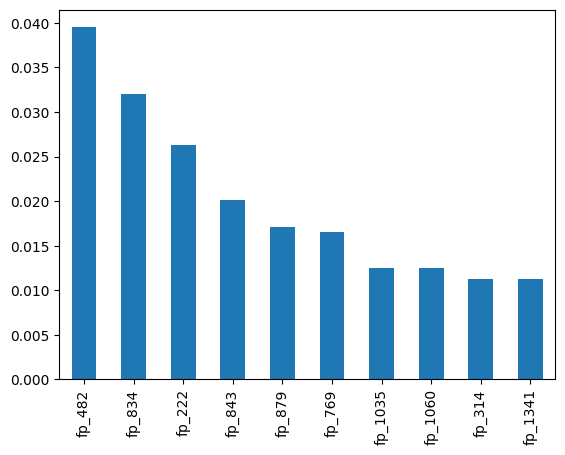

In [233]:
X = np.array([GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(m),radius=3,nBits=2048,useChirality=True) for m in testDF['Smiles']])
y = testDF['final_activity_label']
columns=[f'fp_{i}' for i in range(2048)]

imp=pd.Series(data=rfc.feature_importances_,index=columns).sort_values(ascending=False)
imp[:10].plot.bar()

In [236]:
imp = imp.reset_index()
imp.columns = ['index','feat_imp']
imp

index  feat_imp
0      fp_482  0.039524
1      fp_834  0.031990
2      fp_222  0.026301
3      fp_843  0.020072
4      fp_879  0.017090
...       ...       ...
2043  fp_1112  0.000000
2044   fp_805  0.000000
2045  fp_1124  0.000000
2046   fp_569  0.000000
2047  fp_1688  0.000000

[2048 rows x 2 columns]

In [237]:
s = df_fp.sum().reset_index().merge(imp, on='index')
s[(s[0]<50) & (s['feat_imp']>0.005)]

index   0  feat_imp
180    fp_180   7  0.005527
192    fp_192   6  0.007282
407    fp_407   2  0.007336
525    fp_525   1  0.005769
591    fp_591   1  0.007873
608    fp_608   3  0.006687
682    fp_682   4  0.006359
987    fp_987   4  0.005244
1060  fp_1060  26  0.012500
1126  fp_1126  17  0.005285
1257  fp_1257   8  0.006194
1274  fp_1274  13  0.010982
1292  fp_1292  12  0.007371
1381  fp_1381   1  0.006903
1454  fp_1454   0  0.006764
1797  fp_1797   2  0.005672
1922  fp_1922   3  0.010116

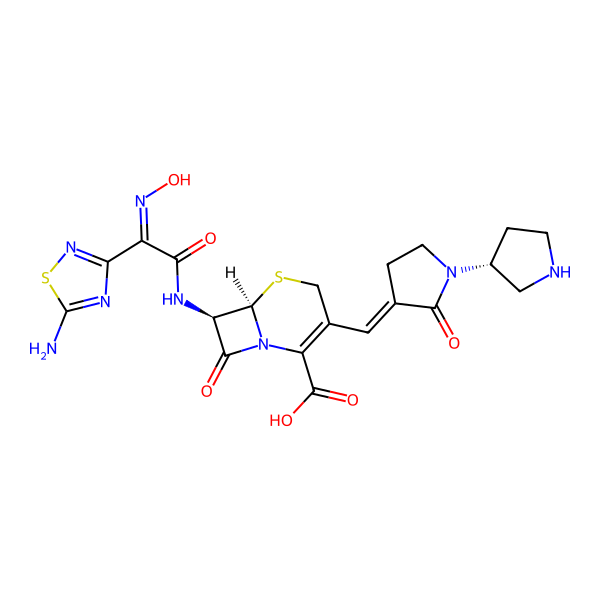

In [238]:
df_fp=pd.DataFrame(X,columns=columns)

indexes=df_fp[(df_fp.fp_192==1)|(df_fp.fp_180==1)].index.values

mols=testDF.loc[indexes ,'Smiles'].tolist()

highlighter_instance=highlighter(mols)

highlighter_instance.render_image(number=2,indexes=False)

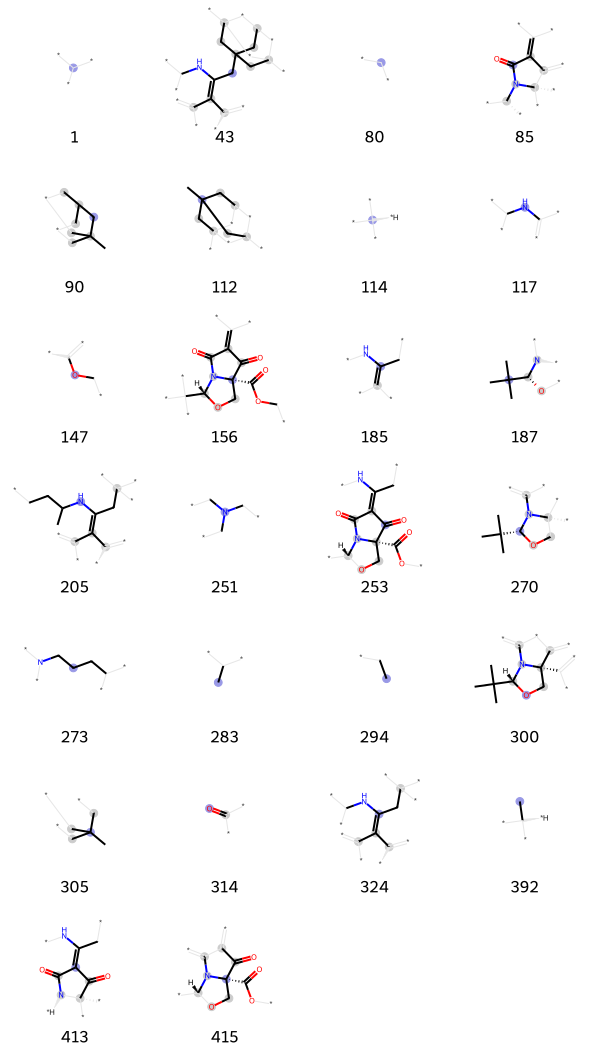

In [66]:
highlighter_instance.fragmentation(n=26,number=0,hyper_finger={'radius':3, 'nBits':2048, 'useChirality':True})[0]

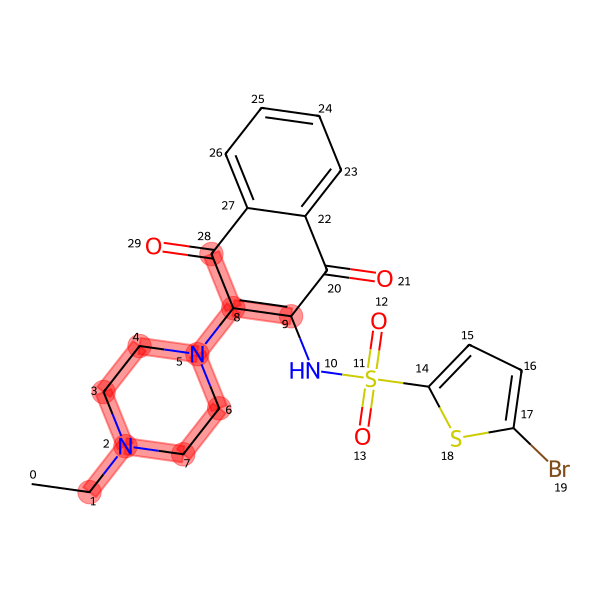

In [72]:
highlighter_instance = highlighter([mols[0]])

highlighter_instance.highlighting(type='morgan',
                                  hyper_finger={'radius':3, 'nBits':2048, 'useChirality':True},
                                  fingerprint_numbers=[[192, 1292]])

# RFC Shapley values

In [275]:
len(X[y==1])

49

In [276]:
explainer = shap.TreeExplainer(rfc, pd.DataFrame(X, columns=columns))

# Get Shap values (extended version has other data returned as well as shap values)
shapley_values_train_extended = explainer(pd.DataFrame(X, columns=columns), check_additivity=False, interactions=False)
shapley_values_train = shapley_values_train_extended.values[:,:,1]
# shapley_values_test_extended = explainer(X, check_additivity=False)
# shapley_values_test = shapley_values_test_extended.values[:,:,1]

# Calculate mean Shapley value for each feature in trainign set
s['mean_shapley_values'] = np.mean(shapley_values_train, axis=0)

# Calculate mean absolute Shapley value for each feature in trainign set
# This will give us the average importance of each feature
s['mean_abs_shapley_values'] = np.mean(
    np.abs(shapley_values_train),axis=0)

In [279]:
s.sort_values(
    by='mean_abs_shapley_values', ascending=False).head(10)

index     0  feat_imp  mean_shapley_values  mean_abs_shapley_values
1922  fp_1922     3  0.010116        -6.372454e-19                 0.016493
314    fp_314  3179  0.011251         4.248302e-19                 0.015970
222    fp_222  3117  0.026301        -4.071290e-19                 0.011531
136    fp_136   173  0.005056         2.655189e-19                 0.010209
470    fp_470     1  0.002439        -4.602328e-19                 0.009362
456    fp_456    91  0.003536         3.009214e-19                 0.009219
1928  fp_1928   692  0.002289        -4.425315e-19                 0.009207
1840  fp_1840   212  0.005756         8.850630e-20                 0.007967
5        fp_5     8  0.002114         1.239088e-19                 0.007499
875    fp_875   580  0.003202         0.000000e+00                 0.006314

In [278]:
# Get top 10 features
importance_top_10 = \
    s.sort_values(by='feat_imp', ascending=False).head(10).index
shapley_top_10 = \
    s.sort_values(
    by='mean_abs_shapley_values', ascending=False).head(10).index

shapley_pos_top_10 = \
    s.sort_values(
    by='mean_shapley_values', ascending=False).head(10).index

# Add to DataFrame
top_10_features = pd.DataFrame()
top_10_features['importances'] = importance_top_10.values
top_10_features['Shapley'] = shapley_top_10.values
top_10_features['Shapley_pos'] = shapley_pos_top_10.values

# Display
top_10_features

importances  Shapley  Shapley_pos
0          482     1922          314
1          834      314          456
2          222      222          136
3          843      136          227
4          879      470          725
5          769      456         1825
6         1035     1928            5
7         1060     1840          140
8          314        5         1126
9         1341      875         1759

## Beeswarm plot

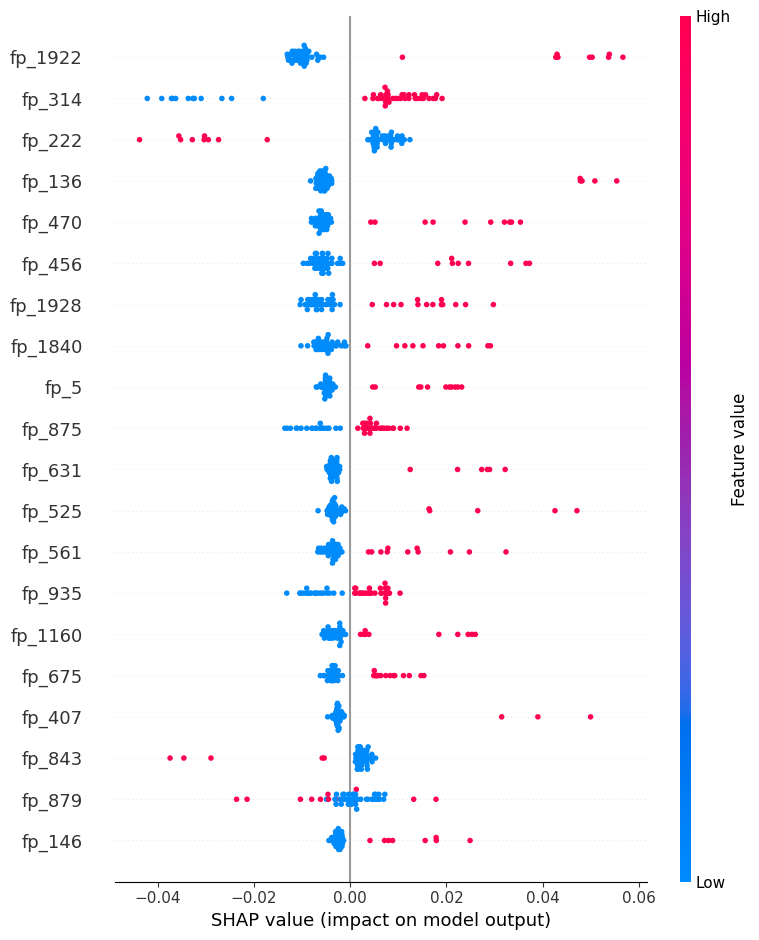

In [281]:
fig = plt.figure(figsize=(6,6))

shap.summary_plot(shap_values = shapley_values_train, 
                  features = X[y==1],
                  feature_names = [f'fp_{i}' for i in range(2048)],
                  max_display=20,
                  show=False)
plt.tight_layout()
plt.show()

## Waterfall plot

In [272]:
np.where(y_prob > 0.7)

(array([ 6, 22, 24, 33, 36], dtype=int64),)

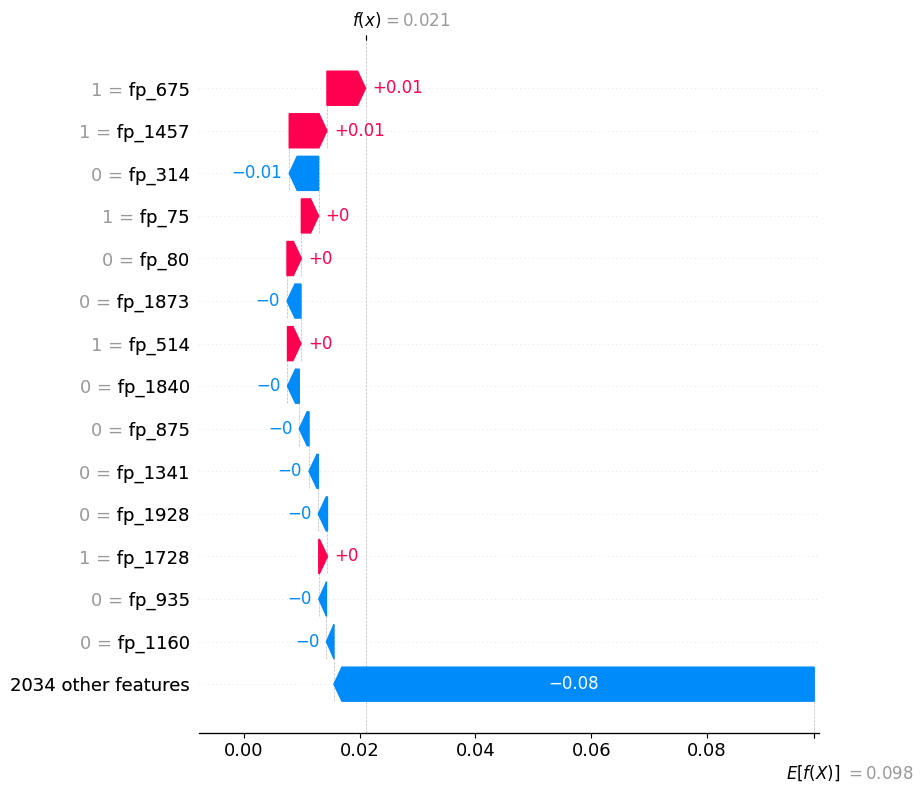

In [271]:
y_prob = rfc.predict_proba(X)[:,1]

# Get the location of an example each where porbability of giving thrombolysis
# is <0.01 or >0.99

location_low_probability = np.where(y_prob < 0.05)[0][0]
location_high_probability = np.where(y_prob > 0.7)[0][0]

shap.plots.waterfall(shapley_values_train_extended[location_low_probability][:,1], 
                     max_display=15)

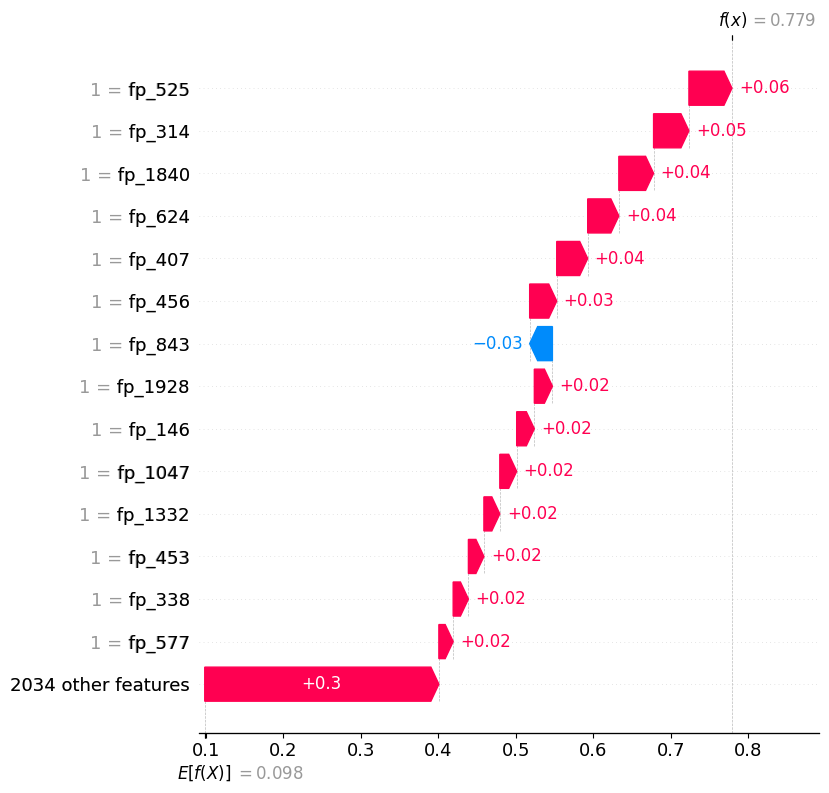

In [273]:
shap.plots.waterfall(shapley_values_train_extended[location_high_probability][:,1], 
                     max_display=15)

In [304]:
indexes

array([ 23,  24,  26,  30,  33, 641], dtype=int64)

In [302]:
shap.plots.waterfall(shapley_values_train_extended[641][:,1], 
                     max_display=15)

IndexError: index 641 is out of bounds for axis 0 with size 49

## Molecular highlight

In [287]:
df_fp=pd.DataFrame(X,columns=columns)

indexes=df_fp[((df_fp.fp_1922==1)&(df_fp.fp_136==1)) & (df_fp.fp_222==0)].index.values

mols=testDF.loc[indexes ,'Smiles'].tolist()

indexes

array([ 23,  24,  26,  30,  33, 641], dtype=int64)

In [288]:
y_prob[indexes]

array([0.69872707, 0.77574873, 0.53786441, 0.64457217, 0.74720249,
       0.25037527])

In [289]:
testDF.loc[indexes, 'final_activity_label'].values

array([1, 1, 1, 1, 1, 0], dtype=int64)

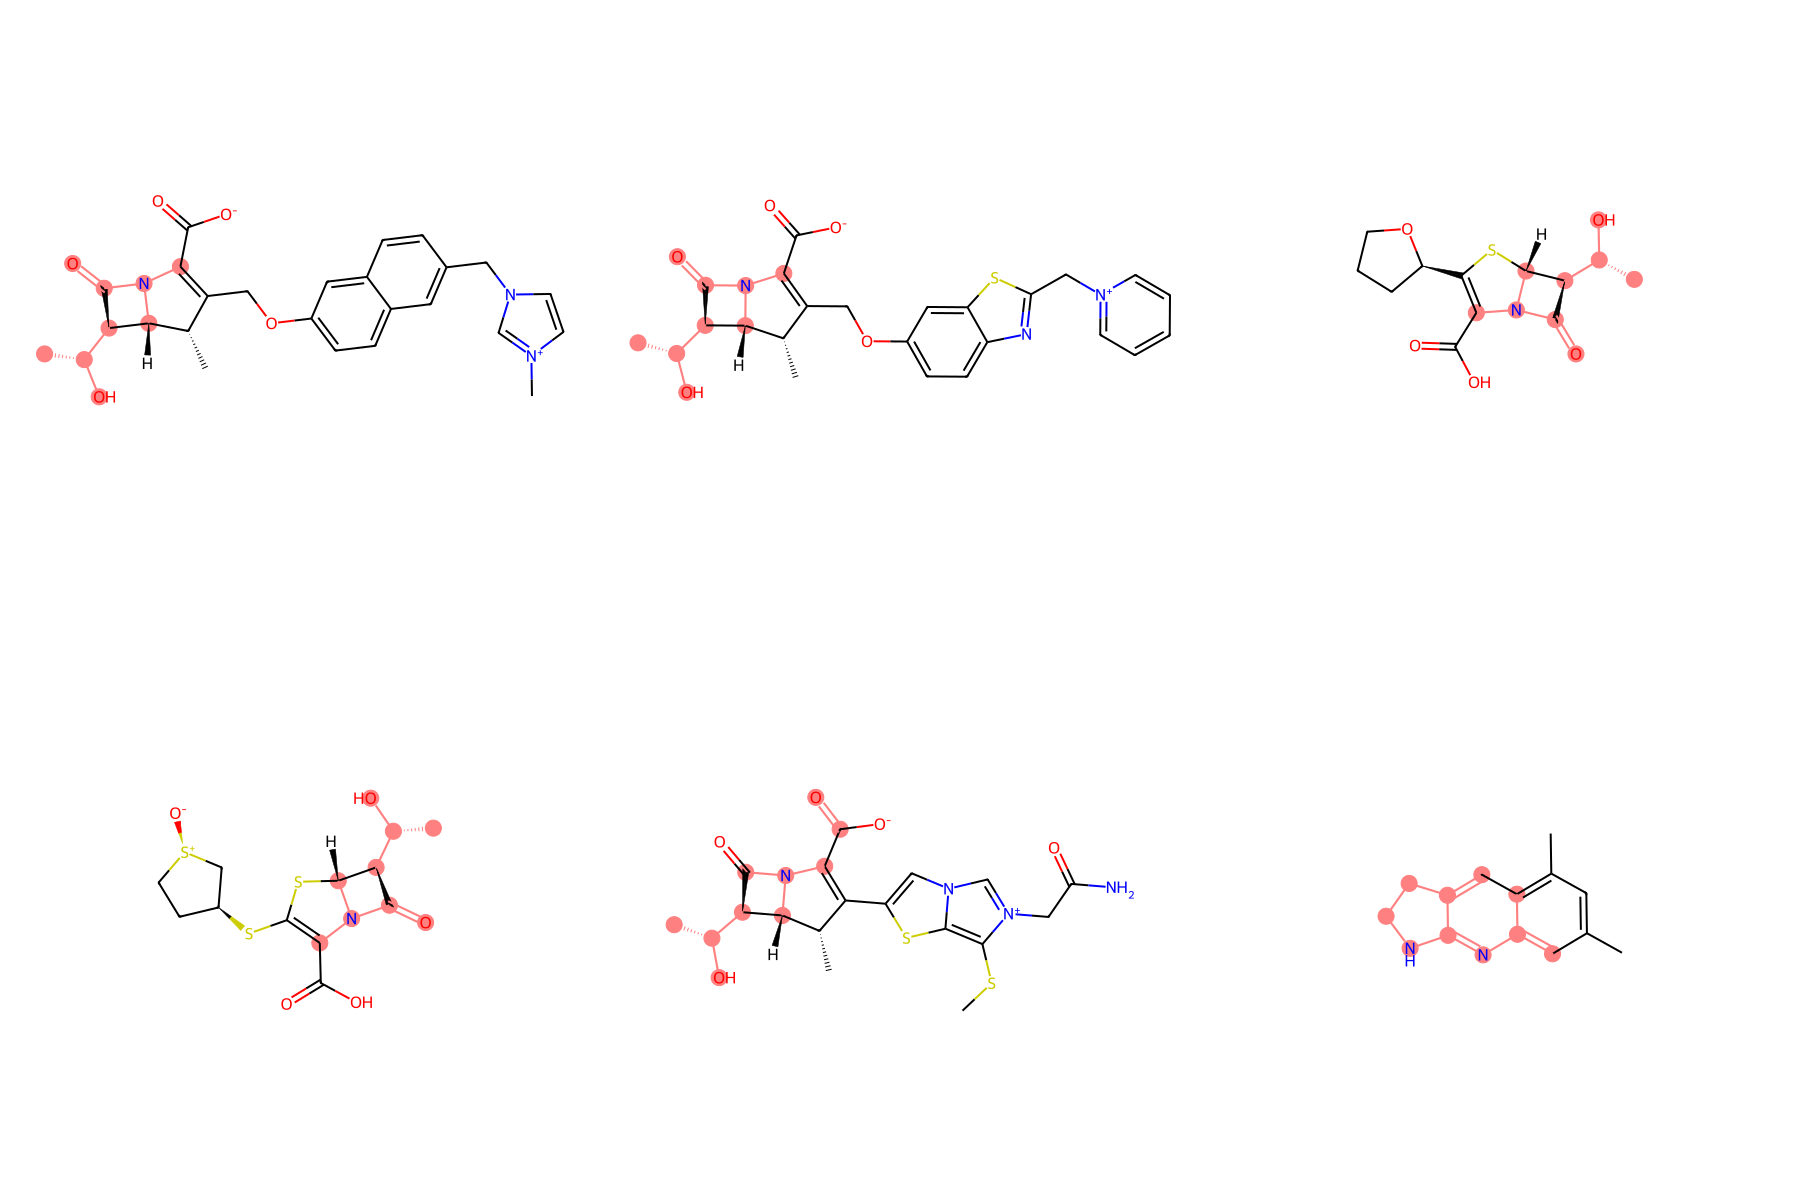

In [296]:
highlighter_instance=highlighter(mols[:6])
highlighter_instance.highlighting(type='morgan',
                                  hyper_finger={'radius':3, 'nBits':2048, 'useChirality':True},
                                  fingerprint_numbers=[[1922, 314, 136]]*6
                                #   fingerprint_numbers=[[268, 1160],[268, 1160],[268, 1160]]
                                  )

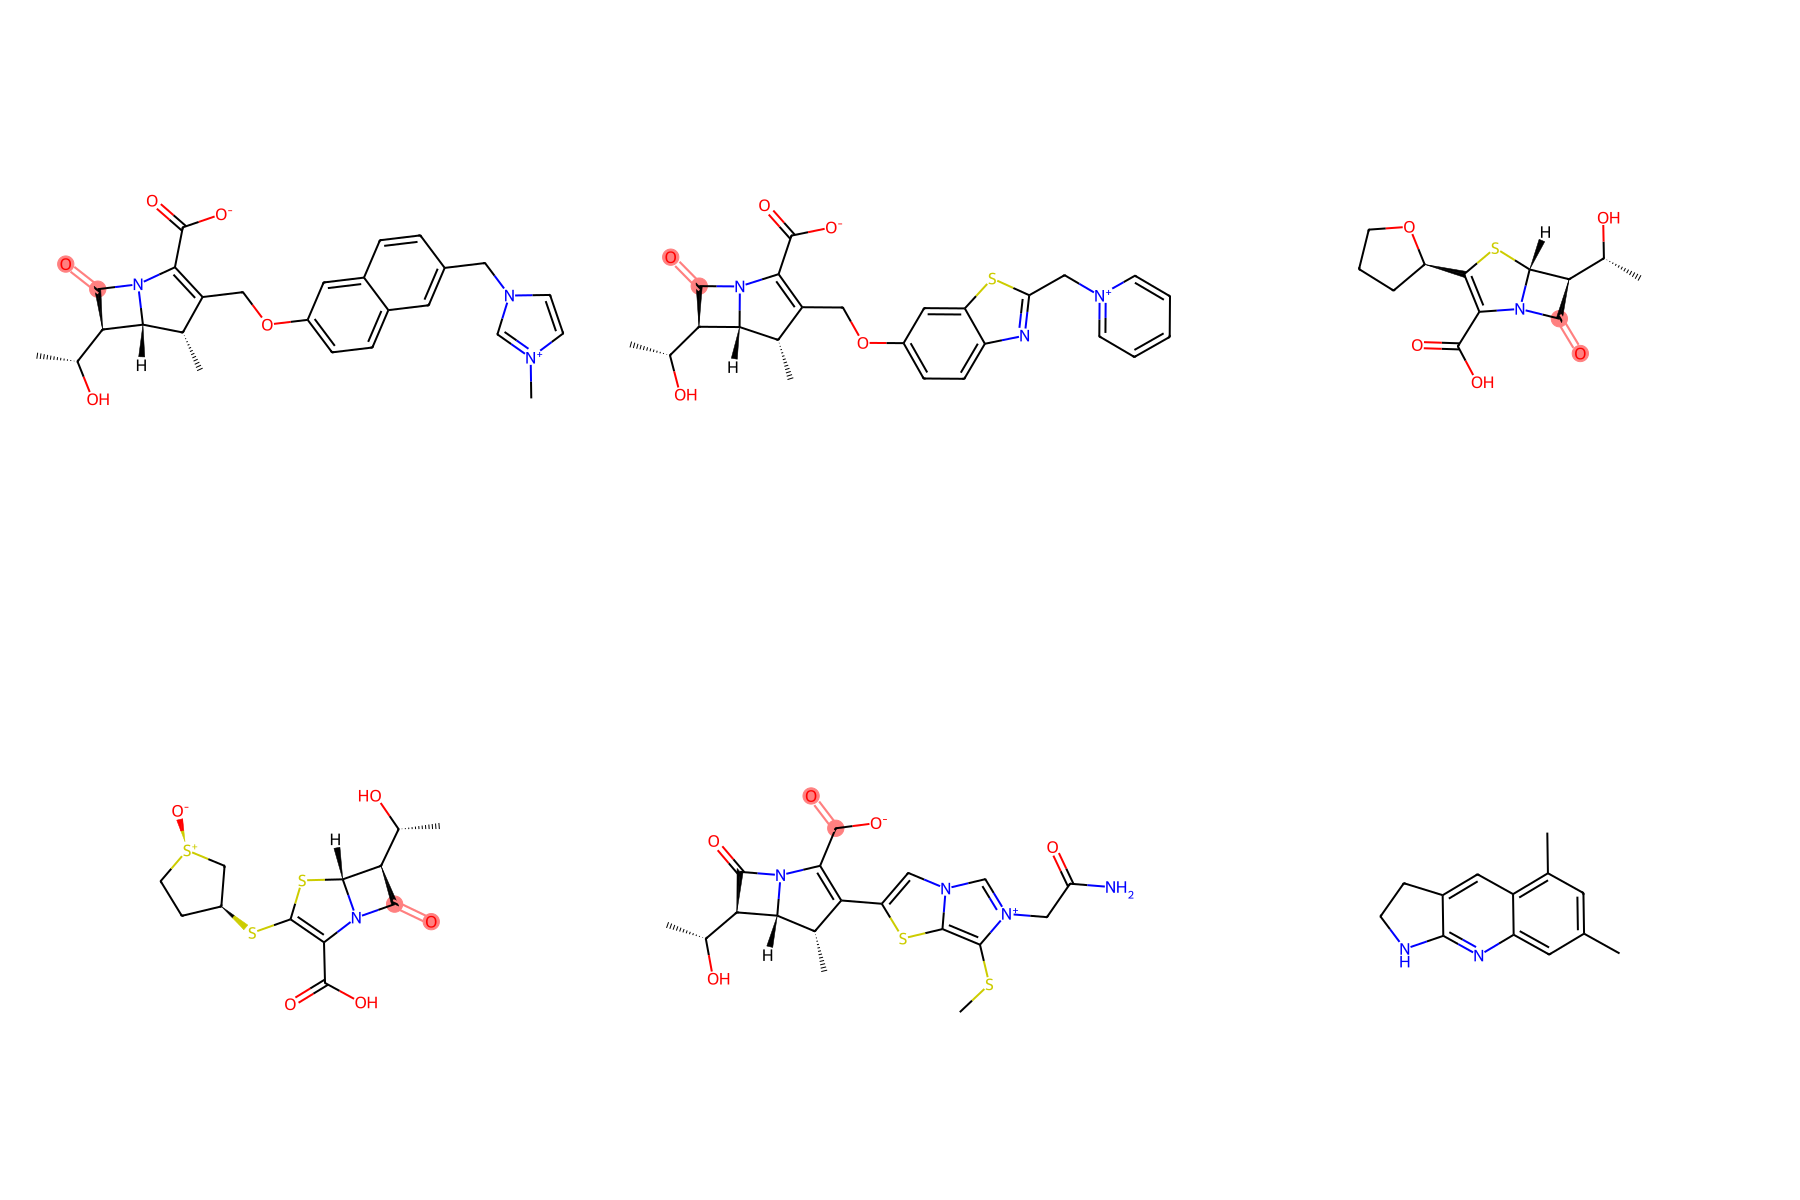

In [301]:
highlighter_instance=highlighter(mols[:6])
highlighter_instance.highlighting(type='morgan',
                                  hyper_finger={'radius':3, 'nBits':2048, 'useChirality':True},
                                  fingerprint_numbers=[[314]]*6
                                #   fingerprint_numbers=[[268, 1160],[268, 1160],[268, 1160]]
                                  )

{2: ((8, 2),), 114: ((19, 0),), 115: ((2, 2),), 161: ((14, 3),), 224: ((6, 2), (10, 2)), 225: ((7, 3),), 268: ((11, 2),), 314: ((0, 1),), 316: ((1, 3),), 352: ((3, 3),), 364: ((4, 3),), 453: ((5, 3),), 454: ((3, 2),), 575: ((23, 3),), 604: ((18, 3),), 650: ((0, 0),), 656: ((2, 0),), 694: ((4, 0),), 736: ((15, 2),), 769: ((8, 3),), 774: ((23, 2),), 780: ((4, 2),), 807: ((12, 0),), 809: ((19, 1),), 845: ((11, 3),), 875: ((23, 1),), 890: ((7, 2), (9, 2)), 896: ((6, 3),), 926: ((6, 0), (7, 0), (8, 0), (9, 0), (10, 0)), 960: ((5, 1),), 1019: ((5, 0),), 1028: ((7, 1), (8, 1), (9, 1)), 1039: ((16, 2),), 1088: ((16, 1), (1, 1)), 1152: ((4, 1),), 1160: ((14, 1),), 1235: ((15, 3),), 1239: ((14, 2),), 1260: ((19, 2),), 1263: ((5, 2),), 1325: ((6, 1), (10, 1)), 1373: ((2, 3),), 1380: ((1, 0), (3, 0), (11, 0), (13, 0), (14, 0), (18, 0)), 1389: ((11, 1),), 1417: ((18, 1),), 1422: ((13, 2),), 1453: ((20, 1), (21, 1), (22, 1)), 1522: ((18, 2),), 1545: ((1, 2),), 1567: ((16, 3),), 1575: ((13, 3),), 159

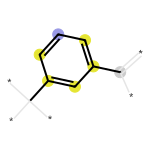

In [215]:
from rdkit.Chem import Draw
mol_temp = Chem.MolFromSmiles(mols[4])
bi = {}
fp = GetMorganFingerprintAsBitVect(mol_temp, radius=3, bitInfo=bi, nBits=2048,useChirality=True)

# Visualize a specific bit (e.g., bit 1567)
print(bi)
mfp2_svg = Draw.DrawMorganBit(mol_temp, 1567, bi, useSVG=True)
mfp2_svg

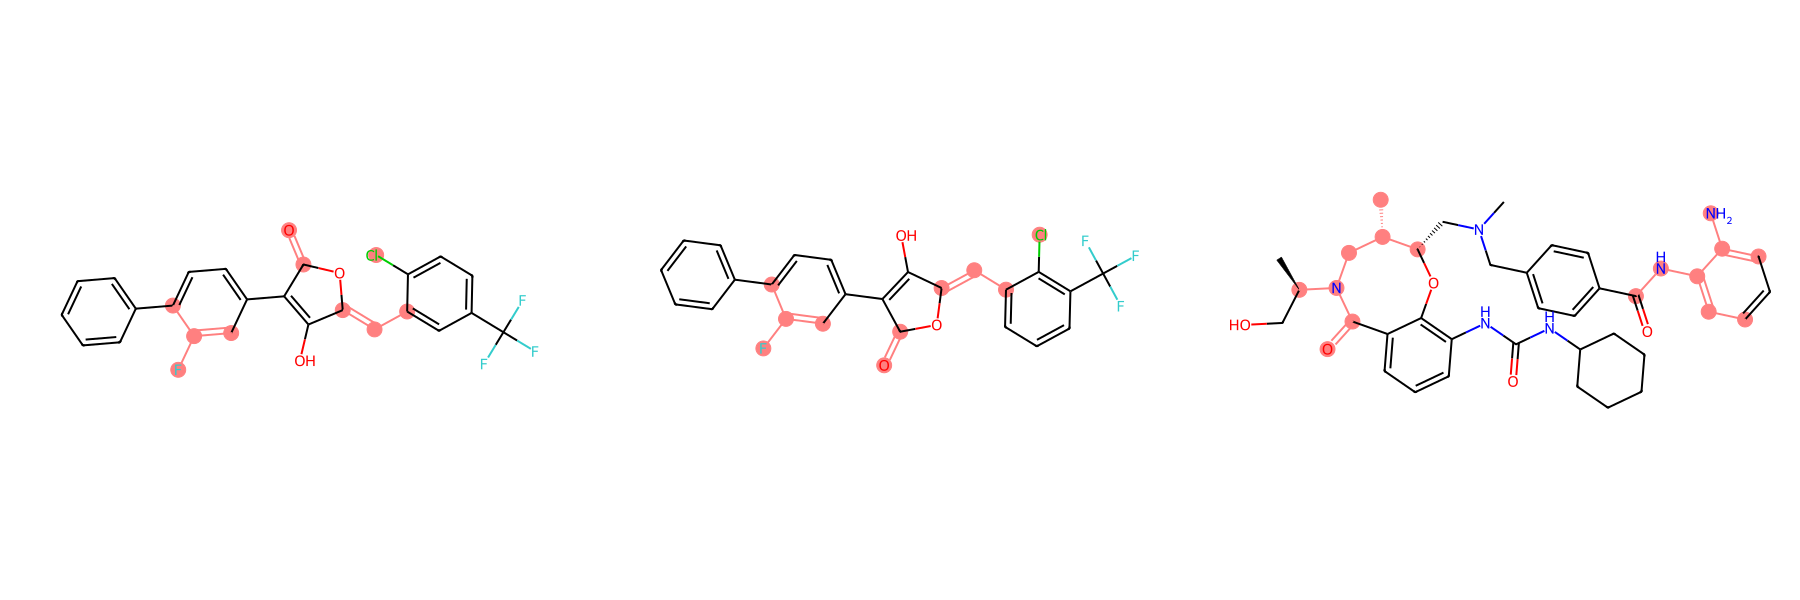

In [114]:
highlighter_instance=highlighter(mols[:3])
highlighter_instance.highlighting(type='morgan',
                                  hyper_finger={'radius':3, 'nBits':2048, 'useChirality':True},
                                  fingerprint_numbers=[shapley_pos_top_10.values,shapley_pos_top_10.values,shapley_pos_top_10.values])

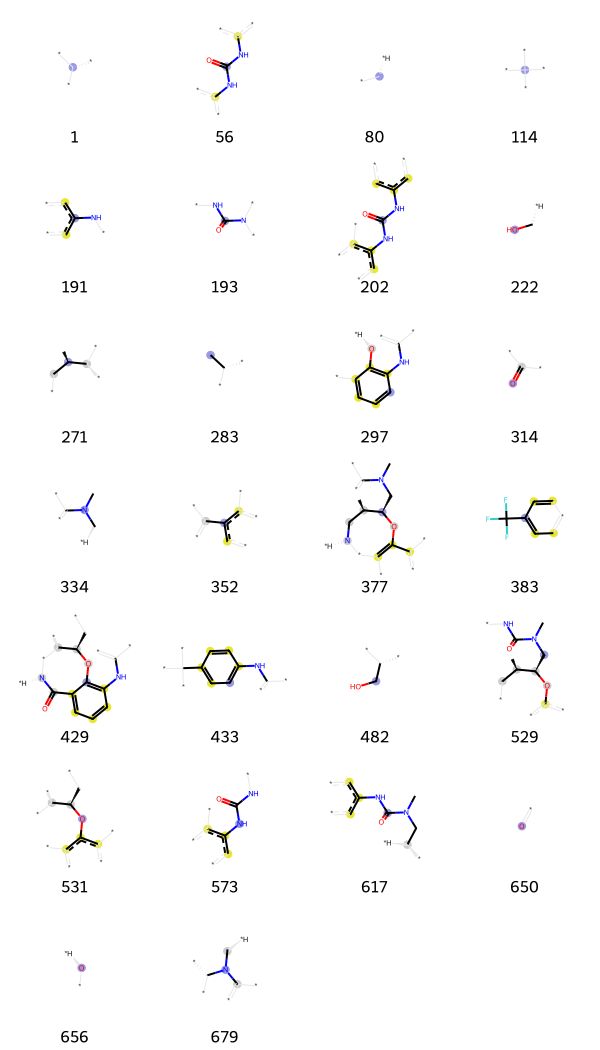

In [92]:
highlighter_instance.fragmentation(n=26,number=0,hyper_finger={'radius':3, 'nBits':2048, 'useChirality':True})[0]

# Monte Carlo Tree Search

In [2]:
trainedMF

FFNMolFormer(
  (base): MolformerModel(
    (embeddings): MolformerEmbeddings(
      (word_embeddings): Embedding(2362, 768, padding_idx=2)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (encoder): MolformerEncoder(
      (layer): ModuleList(
        (0-11): 12 x MolformerLayer(
          (attention): MolformerAttention(
            (self): MolformerSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (rotary_embeddings): MolformerRotaryEmbedding()
              (feature_map): MolformerFeatureMap(
                (kernel): ReLU()
              )
            )
            (output): MolformerSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (dropout

In [26]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

print(count_parameters(trainedMF))
1 - count_parameters(trainedMF.ffn) / count_parameters(trainedMF)

55002626


0.8067803889945182

In [17]:
from chemprop.interpret import MCTSNode, extract_subgraph, find_clusters
from pneumococcusVS.models.molformer.lightning_model import FFN, FFNMolFormer
from transformers import AutoTokenizer
from typing import List, Callable, Set, Dict
import torch
from tqdm.notebook import tqdm
import glob
from functools import partial

trainedMF = FFNMolFormer.load_from_checkpoint('model_garden/SingleTunedCEMolFormerSeed3.ckpt')
tokenizer = AutoTokenizer.from_pretrained("ibm/MoLFormer-XL-both-10pct", trust_remote_code=True)
rfc = joblib.load(r'model_garden\tuned_rfc_morgan_seed3.joblib')
rfc

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       min_samples_leaf=4, n_estimators=200, random_state=3)

In [17]:
pred_colname = 'tuned_MF_ens_pred'   # 'prediction'
# predicted_actives = pd.read_csv(r'processed_datasets\top_algo_holdout_set_output_v7_tuned.csv')
predicted_actives = pd.read_csv(r'processed_datasets\v7_predictions_for_stacking_v2.csv')
predicted_actives = predicted_actives[predicted_actives[pred_colname]>=0.5].reset_index(drop=True)
print(predicted_actives.shape)
predicted_actives.head(2)

(1939, 10)


Smiles  cluster_id  \
0  COc1c(N2C[C@@H]3CCCN[C@@H]3C2)c(F)cc2c(=O)c(C(...           6   
1  COc1c(N2CC3(CC3)[C@](C)(N)C2)c(F)cc2c(=O)c(C(=...           6   

   final_activity_label  vanilla_rfc_morgan_pred  vanilla_rfc_molfeat_pred  \
0                     1                    0.941                      0.95   
1                     1                    0.994                      1.00   

    cp_pred  cp_uncertainty  tuned_MF_ens_pred  tuned_MF_ens_uncertainty  \
0  0.820686        0.147891           0.833028                  0.061852   
1  0.847289        0.120092           0.812073                  0.058824   

   tuned_rfc_morgan_pred  
0               0.942229  
1               0.986232

In [6]:
predicted_actives.final_activity_label.mean()

0.7593800978792822

## Modifying ChemProp functions for MolFormer

In [7]:
def mcts_rollout(node: MCTSNode,
                 state_map: Dict[str, MCTSNode],
                 orig_smiles: str,
                 clusters: List[Set[int]],
                 atom_cls: List[Set[int]],
                 nei_cls: List[Set[int]],
                 scoring_function: Callable[[List[str]], List[float]],
                 min_atoms:int=8) -> float:
    """
    A Monte Carlo Tree Search rollout from a given :class:`MCTSNode`.

    :param node: The :class:`MCTSNode` from which to begin the rollout.
    :param state_map: A mapping from SMILES to :class:`MCTSNode`.
    :param orig_smiles: The original SMILES of the molecule.
    :param clusters: Clusters of atoms.
    :param atom_cls: Atom indices in the clusters.
    :param nei_cls: Neighboring clusters.
    :param scoring_function: A function for scoring subgraph SMILES using a Chemprop model.
    :return: The score of this MCTS rollout.
    """
    cur_atoms = node.atoms
    if len(cur_atoms) <= min_atoms:
        return node.P

    # Expand if this node has never been visited
    if len(node.children) == 0:
        cur_cls = set([i for i, x in enumerate(clusters) if x <= cur_atoms])
        for i in cur_cls:
            leaf_atoms = [a for a in clusters[i] if len(atom_cls[a] & cur_cls) == 1]
            if len(nei_cls[i] & cur_cls) == 1 or len(clusters[i]) == 2 and len(leaf_atoms) == 1:
                new_atoms = cur_atoms - set(leaf_atoms)
                new_smiles, _ = extract_subgraph(orig_smiles, new_atoms)
                if new_smiles in state_map:
                    new_node = state_map[new_smiles]  # merge identical states
                else:
                    new_node = MCTSNode(new_smiles, new_atoms)
                if new_smiles:
                    node.children.append(new_node)

        state_map[node.smiles] = node
        if len(node.children) == 0:
            return node.P  # cannot find leaves

        scores = scoring_function([x.smiles for x in node.children])
        for child, score in zip(node.children, scores):
            child.P = score

    sum_count = sum(c.N for c in node.children)
    selected_node = max(node.children, key=lambda x: x.Q() + x.U(sum_count))
    v = mcts_rollout(selected_node, state_map, orig_smiles, clusters, atom_cls, nei_cls, scoring_function)
    selected_node.W += v
    selected_node.N += 1

    return v


def mcts(smiles: str,
         scoring_function: Callable[[List[str]], List[float]],
         n_rollout: int,
         max_atoms: int,
         prop_delta: float) -> List[MCTSNode]:
    """
    Runs the Monte Carlo Tree Search algorithm.

    :param smiles: The SMILES of the molecule to perform the search on.
    :param scoring_function: A function for scoring subgraph SMILES using a Chemprop model.
    :param n_rollout: THe number of MCTS rollouts to perform.
    :param max_atoms: The maximum number of atoms allowed in an extracted rationale.
    :param prop_delta: The minimum required property value for a satisfactory rationale.
    :return: A list of rationales each represented by a :class:`MCTSNode`.
    """
            
    mol = Chem.MolFromSmiles(smiles)
    if mol.GetNumAtoms() > 50:
        n_rollout = 1

    clusters, atom_cls = find_clusters(mol)
    nei_cls = [0] * len(clusters)
    for i, cls in enumerate(clusters):
        nei_cls[i] = [nei for atom in cls for nei in atom_cls[atom]]
        nei_cls[i] = set(nei_cls[i]) - {i}
        clusters[i] = set(list(cls))
    for a in range(len(atom_cls)):
        atom_cls[a] = set(atom_cls[a])

    root = MCTSNode(smiles, set(range(mol.GetNumAtoms())))
    state_map = {smiles: root}
    for _ in range(n_rollout):
        mcts_rollout(root, state_map, smiles, clusters, atom_cls, nei_cls, scoring_function)

    rationales = [node for _, node in state_map.items() if len(node.atoms) <= max_atoms and node.P >= prop_delta]

    return rationales

## Scoring Function

In [55]:
from typing import List
def rf_scoring_function(smiles:List[str]):
    morgan_fp = np.array([GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(m),radius=3,nBits=2048,useChirality=True) for m in smiles])
    outputs = rfc.predict_proba(morgan_fp)[:,1]
    return outputs

In [6]:
def mf_scoring_function(smiles:List[str], trainedMF:List) -> List[float]:
    MF_inputs = tokenizer(smiles, return_tensors="pt", padding='max_length', max_length=800)
    MF_inputs = MF_inputs.to(device='cuda')
    with torch.no_grad():
        ensemble_y_scores = []
        for model in trainedMF:
            model.to(device='cuda')
            model.eval()
            outputs = model(**MF_inputs)
            ensemble_y_scores.append(outputs[:,1])
        
        ensemble_y_scores = torch.vstack(ensemble_y_scores)
        ensemble_y_scores = 1 / (1 + torch.exp(-ensemble_y_scores))
        agg_y_scores = torch.median(ensemble_y_scores, dim=0).values
    return agg_y_scores.cpu().numpy()

model_files = glob.glob(rf'model_garden*')
trained_models = [FFNMolFormer.load_from_checkpoint(path).to(device='cuda') for path in model_files]
mf_scoring_function = partial(mf_scoring_function, trainedMF=)

In [99]:
def mf_scoring_function(smiles:List[str]) -> List[float]:
    MF_inputs = tokenizer(smiles, return_tensors="pt", padding='max_length', max_length=800).to(device='cuda')
    trainedMF.to(device='cuda').eval()
    with torch.no_grad():
        outputs = trainedMF(**MF_inputs)
        outputs = 1/(1+torch.exp(-outputs[:,1]))
    return outputs.cpu().numpy()

In [102]:
mf_scoring_function(['Fc1c[cH:1]c2[c:1](c[cH:1]c(=O)n2c1)C1CC1'])

array([0.00063371], dtype=float32)

In [26]:
predicted_actives.Smiles.values.tolist()[:1]

['COc1c(N2C[C@@H]3CCCN[C@@H]3C2)c(F)cc2c(=O)c(C(=O)O)cn(C3CC3)c12']

In [38]:
mf_scoring_function(predicted_actives.Smiles.values.tolist()[:1])

array([0.8707913], dtype=float32)

In [25]:
predicted_actives.tuned_MF_ens_pred.iloc[30:]

30    0.510176
31    0.542870
32    0.549969
33    0.551809
34    0.514030
35    0.567331
36    0.517422
37    0.615421
Name: tuned_MF_ens_pred, dtype: float64

In [24]:
predicted_actives.final_activity_label.iloc[30:].mean()

0.0

## Running Interpretation

In [21]:
# MCTS options
rollout = 10  # number of MCTS rollouts to perform. If mol.GetNumAtoms() > 50, consider setting n_rollout = 1 to avoid long computation time

C_PUCT = 10.0  # constant that controls the level of exploration

max_atoms = 20  # maximum number of atoms allowed in an extracted rationale

MIN_ATOMS = 8  # minimum number of atoms in an extracted rationale

prop_delta = 0.2  # Minimum score to count as positive.
# In this algorithm, if the predicted property from the substructure if larger than prop_delta, the substructure is considered satisfactory.
# This value depends on the property you want to interpret. 0.5 is a dummy value for demonstration purposes

num_rationales_to_keep = 5  # number of rationales to keep for each molecule

global C_PUCT, MIN_ATOMS

In [28]:
property_for_interpretation = 'antibiotic'
results_df = {"smiles": [], property_for_interpretation: []}

for i in range(num_rationales_to_keep):
    results_df[f"rationale_{i}"] = []
    results_df[f"rationale_{i}_score"] = []

for i, smiles in tqdm(enumerate(predicted_actives.Smiles.values.tolist())):
    # print([smiles])
    # score = rf_scoring_function([smiles])[0]
    # if score > prop_delta:
    rationales = mcts(
        smiles=smiles,
        scoring_function=mf_scoring_function,
        n_rollout=rollout,
        max_atoms=max_atoms,
        prop_delta=prop_delta,
        # min_atoms=min_atoms,
        # c_puct=c_puct,
    )
    # else:
    #     rationales = []

    results_df["smiles"].append(smiles)
    results_df[property_for_interpretation].append(predicted_actives[pred_colname].values[i])

    if len(rationales) == 0:
        for i in range(num_rationales_to_keep):
            results_df[f"rationale_{i}"].append(None)
            results_df[f"rationale_{i}_score"].append(None)
    else:
        min_size = min(len(x.atoms) for x in rationales)
        min_rationales = [x for x in rationales if len(x.atoms) == min_size]
        rats = sorted(min_rationales, key=lambda x: x.P, reverse=True)

        for i in range(num_rationales_to_keep):
            if i < len(rats):
                results_df[f"rationale_{i}"].append(rats[i].smiles)
                results_df[f"rationale_{i}_score"].append(rats[i].P)
            else:
                results_df[f"rationale_{i}"].append(None)
                results_df[f"rationale_{i}_score"].append(None) 

0it [00:00, ?it/s]

[21:30:47] Can't kekulize mol.  Unkekulized atoms: 2 3 13 15 16 17 22 23 27
[21:30:47] Can't kekulize mol.  Unkekulized atoms: 3 4 9 10 12 22 24 25 26
[21:30:47] Can't kekulize mol.  Unkekulized atoms: 3 4 9 10 11 12 14 24 25
[21:30:48] Can't kekulize mol.  Unkekulized atoms: 3 4 9 10 11 12 13 23 24
[21:30:48] Can't kekulize mol.  Unkekulized atoms: 2 3 8 9 10 11 12 22 23
[21:30:48] Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 5 6 7 17 18
[21:30:48] Can't kekulize mol.  Unkekulized atoms: 0 1 2 7 8 9 10 11 21
[21:30:48] Can't kekulize mol.  Unkekulized atoms: 0 1 2 7 8 9 10 11 17
[21:30:48] Can't kekulize mol.  Unkekulized atoms: 0 1 2 7 8 9 10 11 13
[21:30:48] Can't kekulize mol.  Unkekulized atoms: 0 5 6 7 8 9 10 11 12
[21:30:48] Can't kekulize mol.  Unkekulized atoms: 0 5 6 7 8
[21:30:48] Can't kekulize mol.  Unkekulized atoms: 2 3 13 14 15 16 21 22 26
[21:30:49] Can't kekulize mol.  Unkekulized atoms: 3 4 9 10 12 22 23 24 25
[21:30:49] Can't kekulize mol.  Unkekulized atoms: 2 3

In [29]:
ResDF = pd.DataFrame(results_df)
ResDF.to_csv(r'processed_datasets\v7__mf_mcts_rationale.csv', index=False)
ResDF

smiles  antibiotic  \
0     COc1c(N2C[C@@H]3CCCN[C@@H]3C2)c(F)cc2c(=O)c(C(...    0.833028   
1     COc1c(N2CC3(CC3)[C@](C)(N)C2)c(F)cc2c(=O)c(C(=...    0.812073   
2        CC(=O)NC[C@H]1CN(c2ccc(N3CCOCC3)c(F)c2)C(=O)O1    0.540776   
3     CO/C(C)=C1/NC(=O)[C@H]([C@@H](C)O)NC(=O)c2csc(...    0.970867   
4     CCN1CCN(C(=O)N[C@@H](C(=O)N[C@@H]2C(=O)N3[C@@H...    0.627817   
...                                                 ...         ...   
1934  N#Cc1nn(-c2c(Cl)cc(C(F)(F)F)cc2Cl)c(N)c1S(=O)C...    0.567331   
1935  CC1NC(=O)C2CCCN2C(=O)C(CC(N)=O)NC(=O)C2CSSCC(N...    0.517054   
1936  CCC(C(C)O)n1ncn(-c2ccc(N3CCN(c4ccc(OCC5COC(Cn6...    0.517422   
1937  COc1ccc(-n2nc(C(N)=O)c3c2C(=O)N(c2ccc(N4CCCCC4...    0.615421   
1938  CS(=O)(=O)CCNCc1ccc(-c2ccc3ncnc(Nc4ccc(OCc5ccc...    0.565067   

                                            rationale_0  rationale_0_score  \
0                  O=c1c([CH3:1])cn(C2CC2)[cH:1][cH:1]1           0.258923   
1     O.O=c1c([CH3:1])cn([C@@H]2C[C@@H]2F)[cH:1][cH:1]1           0.234762   
2                   Fc1cc(N2C[CH2:1]O[CH2:1]2)cc[cH:1]1           0.201622   
3                                                  None                NaN   
4     c1ccc([CH2:1][CH2:1]N[C@H]2[C@H]3S[CH2:1][CH2:...           0.310191   
...                                                 ...                ...   
1934  F[CH2:1]c1cc(Cl)c(-n2n[cH:1]c([SH:1])[cH:1]2)[...           0.540409   
1935                                               None                NaN   
1936        c1ncn(CC2(c3cc[cH:1]c[cH:1]3)C[CH2:1]CO2)n1           0.276980   
1937  c1cc([NH2:1])ccc1N1CCc2c(n([CH3:1])n[cH:1]2)[C...           0.343876   
1938         c1nc(Nc2ccc([OH:1])[cH:1]c2)[cH:1][cH:1]n1           0.279441   

                                            rationale_1  rationale_1_score  \
0                                                  None                NaN   
1                                                  None                NaN   
2                                                  None                NaN   
3                                                  None                NaN   
4                                                  None                NaN   
...                                                 ...                ...   
1934  F[CH:1](F)c1c[cH:1]c(-n2n[cH:1]c([SH:1])[cH:1]...           0.391092   
1935                                               None                NaN   
1936                                               None                NaN   
1937  c1cc([NH2:1])ccc1N1CCc2c([CH3:1])n[nH:1]c2[CH2...           0.233071   
1938                                               None                NaN   

     rationale_2  rationale_2_score rationale_3  rationale_3_score  \
0           None                NaN        None                NaN   
1           None                NaN        None                NaN   
2           None                NaN        None                NaN   
3           None                NaN        None                NaN   
4           None                NaN        None                NaN   
...          ...                ...         ...                ...   
1934        None                NaN        None                NaN   
1935        None                NaN        None                NaN   
1936        None                NaN        None                NaN   
1937        None                NaN        None                NaN   
1938        None                NaN        None                NaN   

     rationale_4  rationale_4_score  
0           None                NaN  
1           None                NaN  
2           None                NaN  
3           None                NaN  
4           None                NaN  
...          ...                ...  
1934        None                NaN  
1935        None                NaN  
1936        None                NaN  
1937        None                NaN  
1938        None                NaN  

[1939 rows x 12 columns]

In [30]:
ResDF['rationale_0'].isna().sum()

910

In [31]:
ResDF.shape

(1939, 12)

# Rationale Analysis

In [3]:
from umap import UMAP
import pandas as pd
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from rdkit import Chem
from rdkit.Chem import AllChem
from matplotlib import pyplot as plt
from sklearn.metrics import silhouette_score
from matplotlib.colors import TABLEAU_COLORS
from rdkit.Chem import rdRascalMCES
from rdkit import DataStructs
from rdkit.Chem import Draw
from rdkit.Chem import rdFMCS

In [4]:
basedf = pd.read_json(r'processed_datasets\10uM_FP_clustered__resistant_pneumococcus_augmented_dataset_v7.json')[['Smiles','Compound ID', 'adjusted_value_uM', 'source', 'Molecular_Weight']]
basedf = basedf.rename(columns={'Compound ID':'CID'})
basedf.columns

Index(['Smiles', 'CID', 'adjusted_value_uM', 'source', 'Molecular_Weight'], dtype='object')

In [5]:
stem = pd.read_csv(r'processed_datasets\v7_predictions_for_stacking_v2.csv')[['Smiles','cluster_id', 'final_activity_label']]
mfResDF = pd.read_csv(r'processed_datasets\v7__mf_mcts_rationale.csv').rename(columns={'smiles':'Smiles'})
mfResDF =  mfResDF[['Smiles', 'antibiotic', 'rationale_0', 'rationale_0_score']]
rfcResDF = pd.read_csv(r'processed_datasets\v7__rfc_mcts_rationale.csv').rename(columns={'smiles':'Smiles'})
rfcResDF =  rfcResDF[['Smiles', 'antibiotic', 'rationale_0', 'rationale_0_score']]

In [32]:
df = stem.merge(mfResDF, how='left', on='Smiles').merge(rfcResDF, how='left', on='Smiles', suffixes=('_MF', '_RFC'))
df = df.merge(basedf, how='left', on='Smiles')

### beta lactam and quinolone check
blactam = 'O=C1CCN1'
quinolone4 = 'O=C1C=CNC2=CC=CC=C12'
quinolone2 = 'C1=CC=C2C(=C1)C=CC(=O)N2'

df['is_beta_lactam'] = [len(Chem.MolFromSmiles(x).GetSubstructMatches(Chem.MolFromSmiles(blactam)))>0 for x in df['Smiles']]
df['is_quinolone'] = [len(Chem.MolFromSmiles(x).GetSubstructMatches(Chem.MolFromSmiles(quinolone4))) + len(Chem.MolFromSmiles(x).GetSubstructMatches(Chem.MolFromSmiles(quinolone2)))>0  for x in df['Smiles']]
df['is_common_scaffold'] = df['is_beta_lactam'] | df['is_quinolone']
df.head(2)

[13:41:05] Unusual charge on atom 0 number of radical electrons set to zero
[13:41:25] Unusual charge on atom 0 number of radical electrons set to zero
[13:41:25] Unusual charge on atom 0 number of radical electrons set to zero


Smiles  cluster_id  \
0  CC1(C)S[C@@H]2[C@H](NC(=O)Cc3ccccc3)C(=O)N2[C@...           3   
1  COc1c(N2C[C@@H]3CCCN[C@@H]3C2)c(F)cc2c(=O)c(C(...           6   

   final_activity_label  antibiotic_MF                        rationale_0_MF  \
0                     1            NaN                                   NaN   
1                     1       0.833028  O=c1c([CH3:1])cn(C2CC2)[cH:1][cH:1]1   

   rationale_0_score_MF  antibiotic_RFC  \
0                   NaN        0.594398   
1              0.258923        0.942229   

                                     rationale_0_RFC  rationale_0_score_RFC  \
0  O=C(O)[C@@H]1N2C(=O)[C@@H]([NH2:1])[C@H]2S[CH2...               0.240395   
1    O=c1c2cc(F)c([NH2:1])[cH:1]c2n([CH3:1])c[cH:1]1               0.260729   

        CID  adjusted_value_uM  source  Molecular_Weight  is_beta_lactam  \
0  CHEMBL29           0.373804  ChEMBL            334.40            True   
1  CHEMBL32           4.982065  ChEMBL            401.44           False   

   is_quinolone  is_common_scaffold  
0         False                True  
1          True                True

In [18]:
# df['rationale_0_MF'].count()
test = (df.cluster_id==-1)
print('## TEST SET ##')
print('Predicted RFC: ', df[(~df.antibiotic_RFC.isna()) & test].shape[0])
print('Predicted RFC without Rationale: ', df[df.rationale_0_RFC.isna() & (~df.antibiotic_RFC.isna()) & test].shape[0])
print('Predicted MF: ', df[(~df.antibiotic_MF.isna()) & test].shape[0])
print('Predicted MF without Rationale: ', df[df.rationale_0_MF.isna() & (~df.antibiotic_MF.isna()) & test].shape[0])

print('## TRAIN SET ##')
print('Predicted RFC: ', df[(~df.antibiotic_RFC.isna()) & ~test].shape[0])
print('Predicted RFC without Rationale: ', df[df.rationale_0_RFC.isna() & (~df.antibiotic_RFC.isna()) & ~test].shape[0])
print('Predicted MF: ', df[(~df.antibiotic_MF.isna()) & ~test].shape[0])
print('Predicted MF without Rationale: ', df[df.rationale_0_MF.isna() & (~df.antibiotic_MF.isna()) & ~test].shape[0])

## TEST SET ##
Predicted RFC:  18
Predicted RFC without Rationale:  2
Predicted MF:  38
Predicted MF without Rationale:  7
## TRAIN SET ##
Predicted RFC:  2434
Predicted RFC without Rationale:  1316
Predicted MF:  1901
Predicted MF without Rationale:  903


## Rationale similarity

In [19]:
print('## TRAIN SET ##')
print('Predicted RFC & MF: ', df[(~df.antibiotic_RFC.isna()) & (~df.antibiotic_MF.isna()) & ~test].shape[0])
print('Predicted RFC & MF with Rationale: ', df[(~df.rationale_0_RFC.isna()) & (~df.rationale_0_MF.isna()) & ~test].shape[0])

print('## TEST SET ##')
print('Predicted both RFC & MF: ', df[(~df.antibiotic_RFC.isna()) & (~df.antibiotic_MF.isna()) & test].shape[0])
print('Predicted both RFC & MF with Rationale: ', df[(~df.rationale_0_RFC.isna()) & (~df.rationale_0_MF.isna()) & test].shape[0])

## TRAIN SET ##
Predicted RFC & MF:  1855
Predicted RFC & MF with Rationale:  838
## TEST SET ##
Predicted both RFC & MF:  12
Predicted both RFC & MF with Rationale:  10


In [20]:
testCompDF = df[(~df.rationale_0_RFC.isna()) & (~df.rationale_0_MF.isna()) & test]
testCompDF.head()

Smiles  cluster_id  \
41   CCO/N=C(\C(=O)N[C@@H]1C(=O)N2C(C(=O)[O-])=C(Sc...          -1   
88   C[C@H]1NCc2cc(-c3ccc4c(=O)c(C(=O)O)cn(C5CC5)c4...          -1   
143  O=C1O/C(=C\c2ccccc2-c2ccc(Cl)c(Cl)c2)C(O)=C1c1...          -1   
156  Nc1nc(/C(=N/O)C(=O)N[C@@H]2C(=O)N3C(C(=O)O)=C(...          -1   
650  O=C1C(=C(O)CCc2ccccc2)C(=O)N(c2ccc(Cl)cc2)N1c1...          -1   

     final_activity_label  antibiotic_MF  \
41                      1       0.906806   
88                      1       0.637216   
143                     1       0.611566   
156                     1       0.889816   
650                     1       0.546619   

                                        rationale_0_MF  rationale_0_score_MF  \
41                      C[n+]1ccc(-c2csc([SH:1])n2)cc1              0.369818   
88              O=c1c2cc[cH:1][cH:1]c2n(C2CC2)c[cH:1]1              0.220279   
143                  Clc1cc(-c2ccccc2[CH3:1])cc[cH:1]1              0.249311   
156              C1C[C@@H](N2CCC(=[CH2:1])[CH2:1]2)CN1              0.227005   
650  Clc1ccc(N2[CH2:1]C(=[CH:1]C[CH3:1])[CH2:1][NH:...              0.233201   

     antibiotic_RFC                                    rationale_0_RFC  \
41         0.654945  c1sc(SC2=[CH:1]N3[C@H](SC2)[C@H](N[CH2:1][CH3:...   
88         0.613376          O=c1c2cc[cH:1]c([OH:1])c2n(C2CC2)c[cH:1]1   
143        0.680946          O=C1OC(=[CH2:1])C(O)=C1c1cc[cH:1][cH:1]c1   
156        0.555394  O=C1[C@@H]([NH2:1])[C@H]2SCC(/C=C3\CC[NH:1][CH...   
650        0.783125         Clc1ccc(N2[CH2:1][CH2:1][CH2:1][NH:1]2)cc1   

     rationale_0_score_RFC  
41                0.212630  
88                0.208236  
143               0.239184  
156               0.200709  
650               0.255884

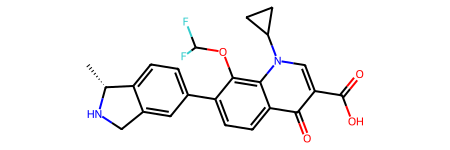

In [34]:
testCompDF['Smiles'].iloc[0]
Chem.MolFromSmiles(testCompDF['Smiles'].iloc[1])

In [31]:
mf_scoring_function(['Sc1n[cH:1]cs1'])

array([0.00815729], dtype=float32)

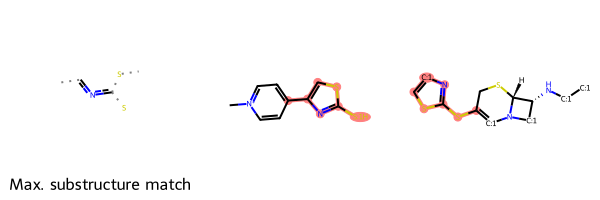

In [37]:
idx = 0
SmilesMCStoGridImage([testCompDF['rationale_0_MF'].iloc[idx], testCompDF['rationale_0_RFC'].iloc[idx]], align_substructure=False)

## MF train vs test

In [7]:
df['has_MF_rationale'] = (~df.rationale_0_MF.isna())
df[(~df.antibiotic_MF.isna()) & (df.cluster_id==-1)].groupby(['final_activity_label','has_MF_rationale'])['Smiles'].count()

final_activity_label  has_MF_rationale
0                     False                3
                      True                13
1                     False                4
                      True                18
Name: Smiles, dtype: int64

In [79]:
df[(~df.antibiotic_MF.isna()) & (df.cluster_id==-1) & (df.is_common_scaffold)].groupby(['final_activity_label','has_MF_rationale'])['Smiles'].count()

final_activity_label  has_MF_rationale
0                     True                1
1                     False               1
                      True                8
Name: Smiles, dtype: int64

In [33]:
mf_rationale = df[~df.rationale_0_MF.isna()].reset_index(drop=True)
mf_rationale['is_test'] = mf_rationale.cluster_id==-1 


mfps = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smiles), 3, 2048) for smiles in mf_rationale['rationale_0_MF'].values]
mf_rationale.is_test.value_counts()
# print(mf_rationale.is_test.value_counts())


is_test
False    998
True      31
Name: count, dtype: int64

In [9]:
mf_rationale.groupby(['is_test', 'final_activity_label'])['Smiles'].count()

is_test  final_activity_label
False    0                       166
         1                       832
True     0                        13
         1                        18
Name: Smiles, dtype: int64

In [78]:
mf_rationale[mf_rationale.is_test].groupby(['is_common_scaffold', 'final_activity_label'])['Smiles'].count()

is_common_scaffold  final_activity_label
False               0                       12
                    1                       10
True                0                        1
                    1                        8
Name: Smiles, dtype: int64

### Tanimoto Similarity

In [34]:
moleculeSim = []
testDF = mf_rationale[mf_rationale['is_test']].reset_index(drop=True)
trainDF = mf_rationale[~mf_rationale['is_test']].reset_index(drop=True)

test_mfps = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smiles), 3, 2048) for smiles in testDF['rationale_0_MF'].values]
train_mfps = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smiles), 3, 2048) for smiles in trainDF['rationale_0_MF'].values]

for idx, target_fp in enumerate(test_mfps):
    simMatrix = DataStructs.BulkTanimotoSimilarity(target_fp, train_mfps)
    maxSim = np.max(simMatrix)
    moleculeSim.append(simMatrix)

testDF['trainMaxSim_idx'] = np.argmax(moleculeSim, axis=1)
testDF['trainMaxSim_val'] = np.max(moleculeSim, axis=1)

In [85]:
cols = ['Smiles','rationale_0_MF', 'rationale_0_score_MF','is_test', 'final_activity_label', 'trainMaxSim_idx', 'trainMaxSim_val', 'CID', 'source', 'adjusted_value_uM']
# testDF[testDF.trainMaxSim_val < testDF.trainMaxSim_val.describe()['25%']][cols]
tmp = testDF[(testDF.trainMaxSim_val < 1 ) & (testDF.final_activity_label==1)
       & (~testDF.is_beta_lactam) & (~testDF.is_quinolone)][cols]
# tmp = testDF[(testDF.final_activity_label==1)
#        & ((testDF.is_beta_lactam) | (testDF.is_quinolone))][cols]
tdf = trainDF.reset_index()[['index', 'Smiles', 'rationale_0_MF', 'adjusted_value_uM']].rename(columns={
                                   'index':'trainMaxSim_idx',
                                   'Smiles':'closest_match_SMILES',
                                   'rationale_0_MF':'closest_match_rationale_0_MF',
                                   'adjusted_value_uM':'closest_match_MIC'})
tmp = tmp.merge(tdf, how='left', on='trainMaxSim_idx')
tmp = tmp.sort_values('trainMaxSim_val')
tmp


Smiles  \
4            Fc1cc2nc(NCCCNCc3ccc(Cl)c(Cl)c3)sc2cc1F   
6  Cc1c(N2CC[C@H](N)C2)c(F)cn2c(=O)c(C(=O)O)cc(C3...   
8  COc1ccc2ncc(F)c(CC[C@H]3OC[C@H](NCc4ccc5c(c4)O...   
1  O=c1ccc2ncc(=O)n3c2n1C[C@H]3CN1CCC(NCc2cc3c(cn...   
7  COc1ccc2ncc(F)c(CC[C@@]3(O)CO[C@@H]4[C@@H](NCc...   
5  COc1ccc(C2=C(O)O/C(=C\c3cccc(C(F)(F)F)c3)C2=O)cc1   
2  O=C1C=CN(c2c(F)cc(N3C[C@H](CNc4ccon4)OC3=O)c(F...   
0  O=C1O/C(=C\c2ccccc2-c2ccc(Cl)c(Cl)c2)C(O)=C1c1...   
3   CCNC(=O)Nc1nc2cc(-c3cccnc3)cc(-c3ncccc3F)c2[nH]1   

                                      rationale_0_MF  rationale_0_score_MF  \
4                               Fc1cc2n[cH:1]sc2cc1F              0.381531   
6                   O=c1[cH:1]cc(C2CC2)[cH:1][nH:1]1              0.358671   
8                     c1cc2nc[cH:1][cH:1]c2nc1[OH:1]              0.238070   
1                     O=c1ccc2ncc(=O)n3c2n1C[CH2:1]3              0.226819   
7  c1n[cH:1][cH:1]c(CC[C:1]2CO[C@@H]3[C@@H]([NH2:...              0.276022   
5       O=C1C(c2ccc([OH:1])cc2)=[CH:1]O/C1=C\[CH3:1]              0.240544   
2                  c1cc(NC[C@H]2C[NH:1][CH2:1]O2)no1              0.494514   
0                  Clc1cc(-c2ccccc2[CH3:1])cc[cH:1]1              0.249311   
3        c1cnc(-c2cc([CH3:1])c[cH:1][cH:1]2)[cH:1]c1              0.291999   

   is_test  final_activity_label  trainMaxSim_idx  trainMaxSim_val  \
4     True                     1              134         0.140625   
6     True                     1              406         0.185185   
8     True                     1              142         0.200000   
1     True                     1              183         0.206349   
7     True                     1              448         0.217949   
5     True                     1              439         0.263158   
2     True                     1              873         0.290323   
0     True                     1              201         0.391304   
3     True                     1              333         0.500000   

             CID  source  adjusted_value_uM  \
4  CHEMBL2016827  ChEMBL           9.942829   
6    CHEMBL16727  ChEMBL           0.086863   
8  CHEMBL4782430  ChEMBL           0.131726   
1  CHEMBL3317856  ChEMBL           0.557376   
7  CHEMBL4788651  ChEMBL           0.240717   
5   CHEMBL382548  ChEMBL           5.520287   
2  CHEMBL3287379  ChEMBL           1.224470   
0   CHEMBL426651  ChEMBL           0.250962   
3   CHEMBL222333  ChEMBL           0.005313   

                                closest_match_SMILES  \
4  CN(C)[C@@H]1C(O)=C(C(N)=O)C(=O)[C@@]2(O)C(O)=C...   
6  COc1c(N2CCc3sc(COC(C)=O)cc3C2)c(F)cc2c(=O)c(C(...   
8  CC[C@H]1OC(=O)[C@H](C)C(=O)[C@H](C)[C@@H](O[C@...   
1  O=c1ccc2ccc(F)c3c2n1C[C@H]3CN1CCCC(CNCc2cc3c(n...   
7  CC[C@H]1OC(=O)[C@H](C)C(=O)[C@H](C)[C@@H](O[C@...   
5  O=C1O/C(=C\c2cccc3ccccc23)C(O)=C1c1cccc(C(F)(F...   
2  N#CCC1=CCN(c2ccc(N3C[C@H](Cn4cc(F)nn4)OC3=O)cc...   
0  O=C1O/C(=C\c2cccc(-c3cc(Cl)cc(Cl)c3)c2)C(O)=C1...   
3  CC[C@H]1OC(=O)[C@H](C)C(=O)[C@H](C)[C@@H](O[C@...   

                  closest_match_rationale_0_MF  closest_match_MIC  
4    Fc1cc(N[CH2:1]c2nccs2)[cH:1][cH:1][cH:1]1           7.161528  
6  O=c1c2c[cH:1][cH:1][cH:1]c2n(C2CC2)c[cH:1]1           0.246650  
8    c1cnc2ccc(N3CCN(C[CH2:1][CH3:1])CC3)cc2c1           0.145672  
1                O=c1ccc2ccc(F)c3c2n1C[CH2:1]3           8.592357  
7   c1cc(CN2CC(N3[CH2:1]O[C:1][CH2:1]3)C2)ccn1           0.671204  
5      O=C1O/C(=C\[CH3:1])C(O)=C1c1ccc[cH:1]c1           1.307737  
2            Fc1cn(C[C@H]2C[NH:1][CH2:1]O2)nn1         124.878244  
0          Clc1cc(-c2cccc([CH3:1])c2)c[cH:1]c1           0.522838  
3                 c1ccc(-c2ccc([CH3:1])cc2)nc1           0.299753

In [82]:
tmp.iloc[5]['rationale_0_MF']

'c1n[cH:1][cH:1]c(CC[C:1]2CO[C@@H]3[C@@H]([NH2:1])CO[C@@H]32)[cH:1]1'

In [40]:
len(Chem.MolFromSmiles(tmp.iloc[1]['Smiles']).GetSubstructMatches(Chem.MolFromSmiles(quinolone2)))

0

In [38]:
testDF[(testDF.is_beta_lactam) | (testDF.is_quinolone)].final_activity_label.value_counts()

final_activity_label
1    8
0    1
Name: count, dtype: int64

CHEMBL4788651 0.21794871794871795


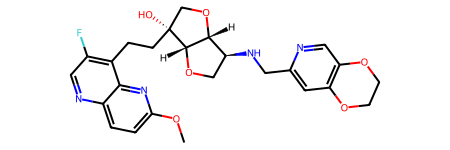

In [467]:
idx = 5
print(tmp.loc[idx]['CID'], tmp.loc[idx]['trainMaxSim_val'])
Chem.MolFromSmiles(tmp.loc[idx]['Smiles'])

Smiles                  CC[C@H]1OC(=O)[C@H](C)C(=O)[C@H](C)[C@@H](O[C@...
final_activity_label                                                    1
cluster_id                                                             11
CID                                                          CHEMBL583695
Name: 448, dtype: object


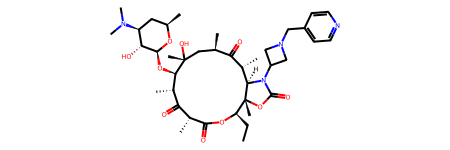

In [469]:
print(trainDF.iloc[tmp.loc[idx]['trainMaxSim_idx']][['Smiles','final_activity_label', 'cluster_id', 'CID']])
Chem.MolFromSmiles(trainDF.iloc[tmp.loc[idx]['trainMaxSim_idx']]['Smiles'])

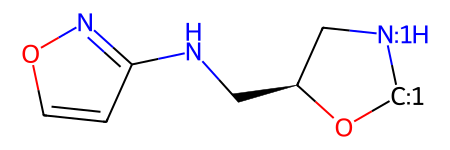

In [461]:
Chem.MolFromSmiles(testDF.loc[idx]['rationale_0_MF'])

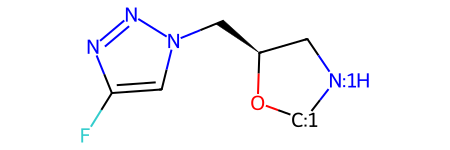

In [462]:
Chem.MolFromSmiles(trainDF.iloc[testDF.loc[idx]['trainMaxSim_idx']]['rationale_0_MF'])

#### Viz

1415 3190


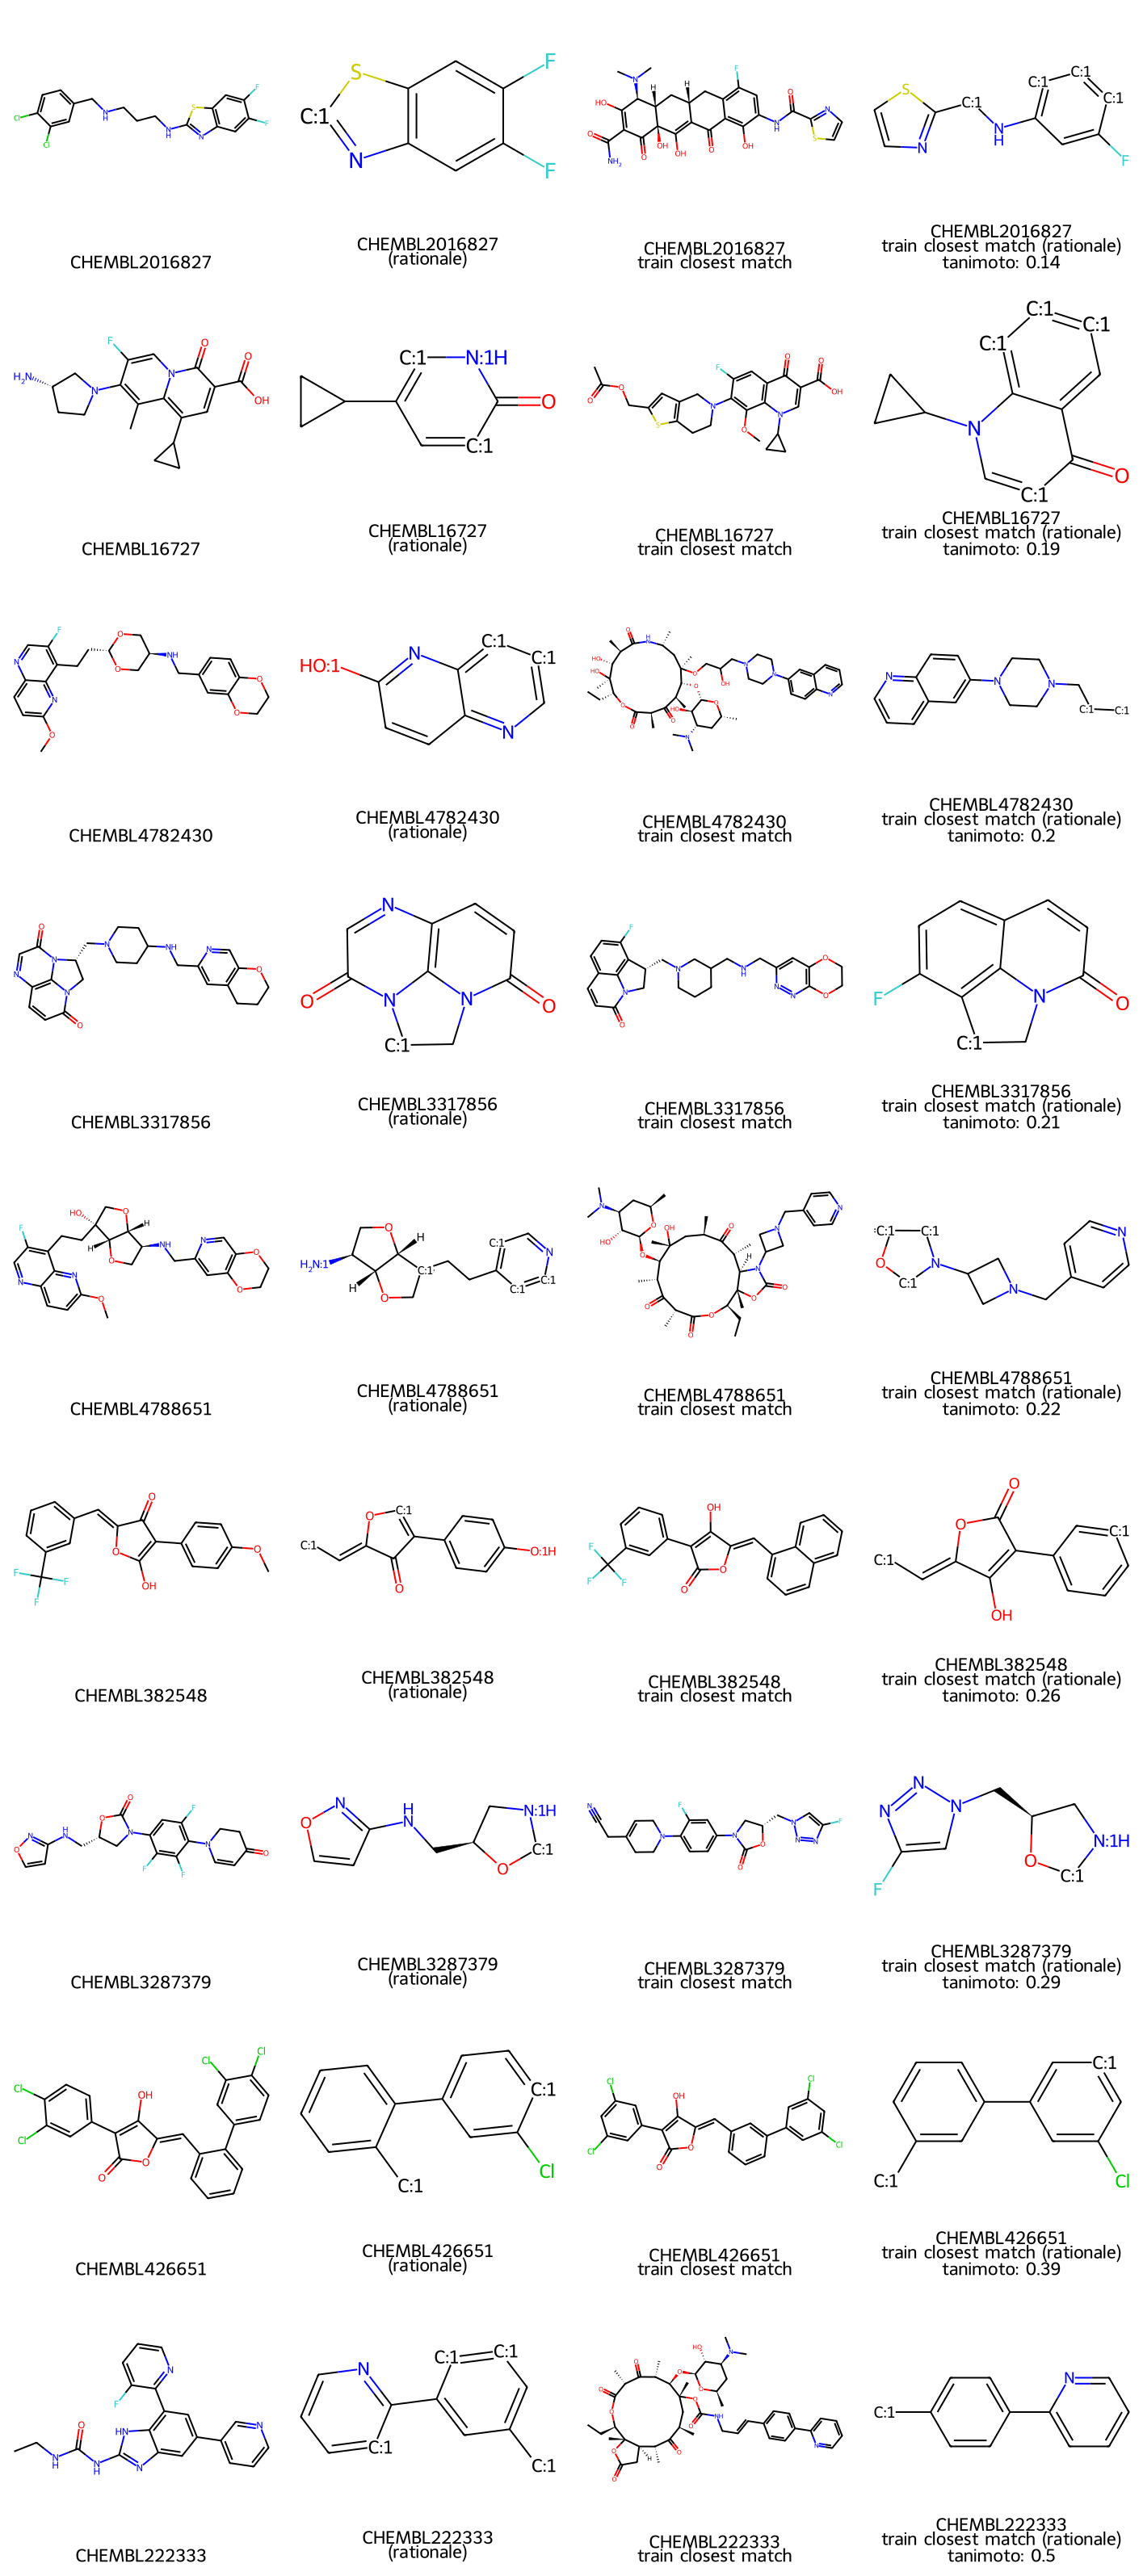

In [86]:
imgs = []
legendFraction = 0.2
legendFontSize = 22
for sm in tmp.itertuples():
    # if sm.cluster_id not in summary[summary['sum']==0].index.values:
    #     continue

    # if sm.cluster_id <13 or sm.cluster_id==-1 or sm.cluster_id>=13:
    #     continue
    # print(sm)
    # break
    uMval = round(sm.adjusted_value_uM, 2)
    d2d = Draw.MolDraw2DCairo(350,350)
    d2d.drawOptions().legendFraction = legendFraction
    d2d.drawOptions().legendFontSize = legendFontSize
    molecule = Chem.MolFromSmiles(sm.Smiles)
    # imgs.append(show_mol(d2d,molecule,legend=f'{sm.CID}\nMIC: {uMval} uM'))
    imgs.append(show_mol(d2d,molecule,legend=f'{sm.CID}'))

for sm in tmp.itertuples():
    d2d = Draw.MolDraw2DCairo(350,350)
    d2d.drawOptions().legendFraction = legendFraction
    d2d.drawOptions().legendFontSize = legendFontSize
    molecule = Chem.MolFromSmiles(sm.rationale_0_MF)
    imgs.append(show_mol(d2d,molecule,legend=f'{sm.CID}\n(rationale)'))


for sm in tmp.itertuples():
    d2d = Draw.MolDraw2DCairo(350,350)
    d2d.drawOptions().legendFraction = legendFraction
    d2d.drawOptions().legendFontSize = legendFontSize
    molecule = Chem.MolFromSmiles(sm.closest_match_SMILES)
    imgs.append(show_mol(d2d,molecule,legend=f'{sm.CID}\ntrain closest match'))


for sm in tmp.itertuples():
    trainMaxSim_val = round(sm.trainMaxSim_val, 2)
    d2d = Draw.MolDraw2DCairo(350,350)
    d2d.drawOptions().legendFraction = legendFraction
    d2d.drawOptions().legendFontSize = legendFontSize
    molecule = Chem.MolFromSmiles(sm.closest_match_rationale_0_MF)
    imgs.append(show_mol(d2d,molecule,legend=f'{sm.CID}\ntrain closest match (rationale)\ntanimoto: {trainMaxSim_val}'))

# imgs.append(show_mol(d2d,doravirine,legend='default palette'))
res = show_images(imgs, nrows=tmp.shape[0])
res

In [52]:
res.save(r'imgs\MCTS_rationale_test_train_MF_low_sim_top3.png', dpi=(4800,4800))

#### ChEMBL substructure search

data are taken by getting bioactivity data of compound matched by substructure search to rationale

In [62]:
import glob, re
bioFiles = glob.glob(r'raw_datasets\*MF_rationale*')
bioFiles

['raw_datasets\\CHEMBL16727_MF_rationale_substructure_match.csv',
 'raw_datasets\\CHEMBL2016827_MF_rationale_substructure_match.csv',
 'raw_datasets\\CHEMBL4782430_MF_rationale_substructure_match.csv']

In [72]:
bioFile = pd.DataFrame()
for file in bioFiles:
    bioact = pd.read_csv(file, delimiter=';')
    bioact['rationale_source'] = re.search('\\\\(\w*?)_', file)[1]
    bioact['rationale_method'] = 'MolFormer'
    bioFile = pd.concat([bioFile, bioact])
bioFile.columns

Index(['Molecule ChEMBL ID', 'Molecule Name', 'Molecule Max Phase',
       'Molecular Weight', '#RO5 Violations', 'AlogP', 'Compound Key',
       'Smiles', 'Standard Type', 'Standard Relation', 'Standard Value',
       'Standard Units', 'pChEMBL Value', 'Data Validity Comment', 'Comment',
       'Uo Units', 'Ligand Efficiency BEI', 'Ligand Efficiency LE',
       'Ligand Efficiency LLE', 'Ligand Efficiency SEI', 'Potential Duplicate',
       'Assay ChEMBL ID', 'Assay Description', 'Assay Type', 'BAO Format ID',
       'BAO Label', 'Assay Organism', 'Assay Tissue ChEMBL ID',
       'Assay Tissue Name', 'Assay Cell Type', 'Assay Subcellular Fraction',
       'Assay Parameters', 'Assay Variant Accession', 'Assay Variant Mutation',
       'Target ChEMBL ID', 'Target Name', 'Target Organism', 'Target Type',
       'Document ChEMBL ID', 'Source ID', 'Source Description',
       'Document Journal', 'Document Year', 'Cell ChEMBL ID', 'Properties',
       'Action Type', 'Standard Text Value', 'r

In [79]:
bioFile['Standard Type'].value_counts().head(20)

Standard Type
MIC           2969
IC50          1058
Inhibition     933
ED50           463
Activity       349
Ratio          170
Potency        161
IFI            102
XC50           101
GI              85
T1/2            85
EC50            82
AC50            72
MIC90           70
GI50            67
Ratio IC50      60
CL              53
CC50            50
F               43
Cmax            39
Name: count, dtype: int64

In [78]:
bioFile['Target Organism'].value_counts().head(20)

Target Organism
Staphylococcus aureus         1366
Homo sapiens                  1225
Escherichia coli               862
Plasmodium falciparum          667
Pseudomonas aeruginosa         366
Streptococcus pneumoniae       293
Enterococcus faecium           247
Mus musculus                   196
Acinetobacter baumannii        167
Rattus norvegicus              146
Streptococcus pyogenes         124
Chlamydia trachomatis          112
Leishmania mexicana            110
Neisseria gonorrhoeae           80
Burkholderia cepacia            57
Canis lupus familiaris          44
Klebsiella pneumoniae           37
Enterococcus faecalis           34
Leishmania donovani             27
Mycobacterium tuberculosis      27
Name: count, dtype: int64

### UMAP viz

In [179]:
umap_red = UMAP(n_neighbors=100, n_components=2, metric='jaccard', random_state=34)
morgan_fps_umap2 = umap_red.fit_transform(mfps)

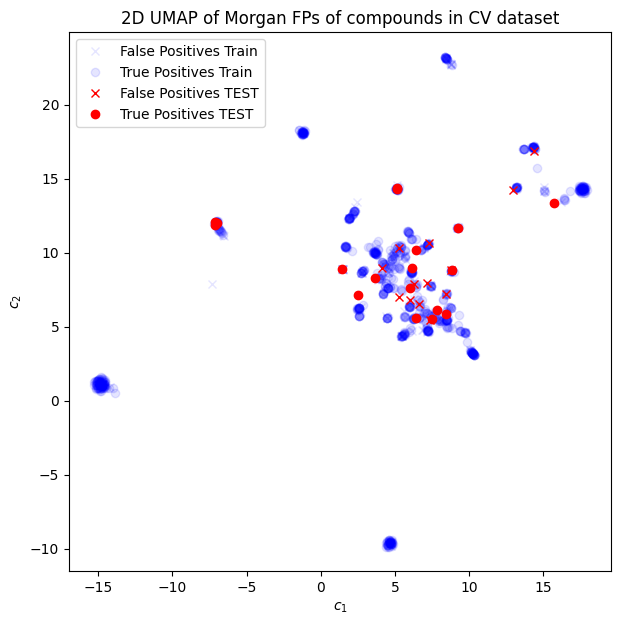

In [180]:
## visualizing the chemical space of ligands targeting viral protein in BindingDB dataset
plt.figure(figsize = (7, 7))

# plt.subplot(122)
plt.plot(morgan_fps_umap2[:, 0][(mf_rationale.final_activity_label==0) & ~mf_rationale['is_test']], 
         morgan_fps_umap2[:, 1][(mf_rationale.final_activity_label==0) & ~mf_rationale['is_test']], 
         'bx', label = 'False Positives Train', alpha=0.1)
plt.plot(morgan_fps_umap2[:, 0][(mf_rationale.final_activity_label==1) & ~mf_rationale['is_test']], 
         morgan_fps_umap2[:, 1][(mf_rationale.final_activity_label==1) & ~mf_rationale['is_test']], 
         'bo', label = 'True Positives Train', alpha=0.1)

plt.plot(morgan_fps_umap2[:, 0][(mf_rationale.final_activity_label==0) & mf_rationale['is_test']], 
         morgan_fps_umap2[:, 1][(mf_rationale.final_activity_label==0) & mf_rationale['is_test']], 
         'rx', label = 'False Positives TEST')
plt.plot(morgan_fps_umap2[:, 0][(mf_rationale.final_activity_label==1) & mf_rationale['is_test']], 
         morgan_fps_umap2[:, 1][(mf_rationale.final_activity_label==1) & mf_rationale['is_test']], 
         'ro', label = 'True Positives TEST')

plt.legend(loc = 'upper left', shadow = False, scatterpoints = 1)
plt.title('2D UMAP of Morgan FPs of compounds in CV dataset')
plt.xlabel('$c_1$')
plt.ylabel('$c_2$')

plt.subplots_adjust(wspace = 0.3)
# plt.savefig('UMAP_before_clustering.png')
plt.show()

k_at_max_score:  40
k_at_max_score (k<10):  5


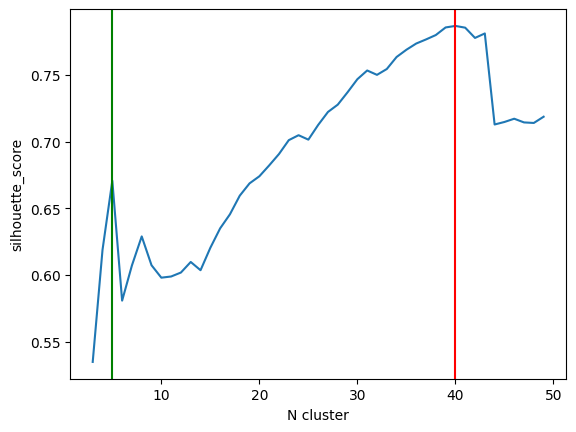

In [181]:
silhouette_scores = []
k_start = 3
k_end = 50
for k in range(k_start,k_end):
    cluster_algo = AgglomerativeClustering(n_clusters=k)
    clustered_morgan_fps_umap2 = cluster_algo.fit_predict(morgan_fps_umap2)
    silhouette_scores.append(silhouette_score(morgan_fps_umap2, clustered_morgan_fps_umap2))

k_at_max_score = np.argmax(silhouette_scores)+k_start
k_at_early_max_score = np.argmax(silhouette_scores[:10-k_start])+k_start
print("k_at_max_score: ", k_at_max_score)
print("k_at_max_score (k<10): ", k_at_early_max_score)
plt.plot(range(k_start,k_end), silhouette_scores)
plt.axvline(x=k_at_max_score, color='r')
plt.axvline(x=k_at_early_max_score, color='g')
plt.xlabel('N cluster')
plt.ylabel('silhouette_score')
plt.show()


### Clustering viz

In [182]:
cluster_algo = AgglomerativeClustering(n_clusters=5, compute_distances=True)
clustered_morgan_fps_umap2 = cluster_algo.fit_predict(morgan_fps_umap2)
mf_rationale['rationale_cluster_id'] = clustered_morgan_fps_umap2
# cv.to_json(f'clustered{k}_CV_10uM_resistant_pneumococcus_augmented_dataset.json')
mf_rationale.groupby(['rationale_cluster_id', 'is_test'])['final_activity_label'].agg(['mean','count','sum'])

mean  count  sum
rationale_cluster_id is_test                      
0                    False    0.831683    606  504
                     True     0.560000     25   14
1                    False    0.886076     79   70
                     True     1.000000      3    3
2                    False    0.834437    151  126
                     True     0.333333      3    1
3                    False    0.767857     56   43
4                    False    0.839623    106   89

['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']


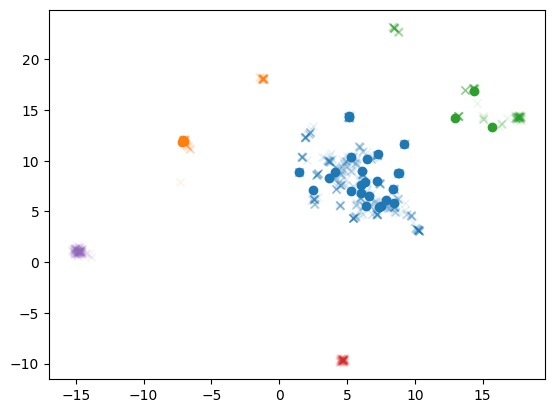

In [183]:
colors = [x for x in TABLEAU_COLORS.keys()]
print(colors[:k_at_early_max_score])
for i, color in enumerate(colors[:k_at_early_max_score]):
    cluster_cond = mf_rationale['rationale_cluster_id']==i
    test_cond = mf_rationale['is_test']
    plt.plot(morgan_fps_umap2[:, 0][cluster_cond&~test_cond], 
             morgan_fps_umap2[:, 1][cluster_cond&~test_cond], 
             'x', color=color, label = f'Cluster {i} Train Set', alpha=0.1)
    plt.plot(morgan_fps_umap2[:, 0][cluster_cond&test_cond], 
             morgan_fps_umap2[:, 1][cluster_cond&test_cond], 
             'o', color=color, label = f'Cluster {i} Test Set')
# plt.legend(loc = 'upper left', shadow = False, scatterpoints = 1, ncols=2)


In [184]:
mf_rationale.groupby(['is_test','final_activity_label'])['rationale_0_score_MF'].agg(['mean', 'median','std'])

mean    median       std
is_test final_activity_label                              
False   0                     0.299508  0.273996  0.094226
        1                     0.309508  0.282288  0.098180
True    0                     0.315789  0.276980  0.107512
        1                     0.300811  0.256322  0.088563

In [272]:
mf_rationale[mf_rationale.is_quinolone & mf_rationale.is_beta_lactam].head(2)

Smiles  cluster_id  \
2     CC(=O)NC[C@H]1CN(c2ccc(N3CCOCC3)c(F)c2)C(=O)O1           6   
4  CC[C@H]1OC(=O)[C@H](C)C(=O)[C@H](C)[C@@H](O[C@...          11   

   final_activity_label  antibiotic_MF  \
2                     1       0.540776   
4                     1       0.654108   

                                    rationale_0_MF  rationale_0_score_MF  \
2              Fc1cc(N2C[CH2:1]O[CH2:1]2)cc[cH:1]1              0.201622   
4  c1cncc(-c2cn(CCCCN3[CH2:1]O[C:1][CH2:1]3)cn2)c1              0.208008   

   antibiotic_RFC                        rationale_0_RFC  \
2        0.936953  Fc1cc(N2C[CH2:1]O[CH2:1]2)ccc1[NH2:1]   
4        0.992651                                    NaN   

   rationale_0_score_RFC  is_test  rationale_cluster_id  is_beta_lactam  \
2               0.254146    False                     4            True   
4                    NaN    False                     0            True   

   is_quinolone  
2          True  
4          True

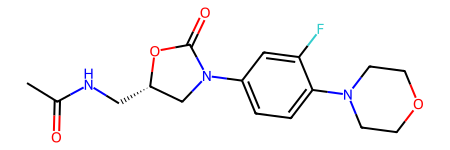

In [273]:
Chem.MolFromSmiles('CC(=O)NC[C@H]1CN(c2ccc(N3CCOCC3)c(F)c2)C(=O)O1')

In [283]:
# tmp = mf_rationale[(mf_rationale.rationale_cluster_id==1) & (mf_rationale.final_activity_label==1)].sample(5)
tmp = mf_rationale[(~mf_rationale.is_beta_lactam) & (~mf_rationale.is_quinolone) & (mf_rationale.is_test) & (mf_rationale.final_activity_label==1)]
print(tmp.shape)
tmp[['Smiles','rationale_0_MF', 'rationale_0_score_MF','is_test', 'rationale_cluster_id']].head()

(10, 13)


Smiles  \
51   O=C1O/C(=C\c2ccccc2-c2ccc(Cl)c(Cl)c2)C(O)=C1c1...   
194  O=c1ccc2ncc(=O)n3c2n1C[C@H]3CN1CCC(NCc2cc3c(cn...   
214  O=C1C=CN(c2c(F)cc(N3C[C@H](CNc4ccon4)OC3=O)c(F...   
234  O=C1C(=C(O)CCc2ccccc2)C(=O)N(c2ccc(Cl)cc2)N1c1...   
480   CCNC(=O)Nc1nc2cc(-c3cccnc3)cc(-c3ncccc3F)c2[nH]1   

                                        rationale_0_MF  rationale_0_score_MF  \
51                   Clc1cc(-c2ccccc2[CH3:1])cc[cH:1]1              0.249311   
194                     O=c1ccc2ncc(=O)n3c2n1C[CH2:1]3              0.226819   
214                  c1cc(NC[C@H]2C[NH:1][CH2:1]O2)no1              0.494514   
234  Clc1ccc(N2[CH2:1]C(=[CH:1]C[CH3:1])[CH2:1][NH:...              0.233201   
480        c1cnc(-c2cc([CH3:1])c[cH:1][cH:1]2)[cH:1]c1              0.291999   

     is_test  rationale_cluster_id  
51      True                     0  
194     True                     0  
214     True                     0  
234     True                     0  
480     True                     0

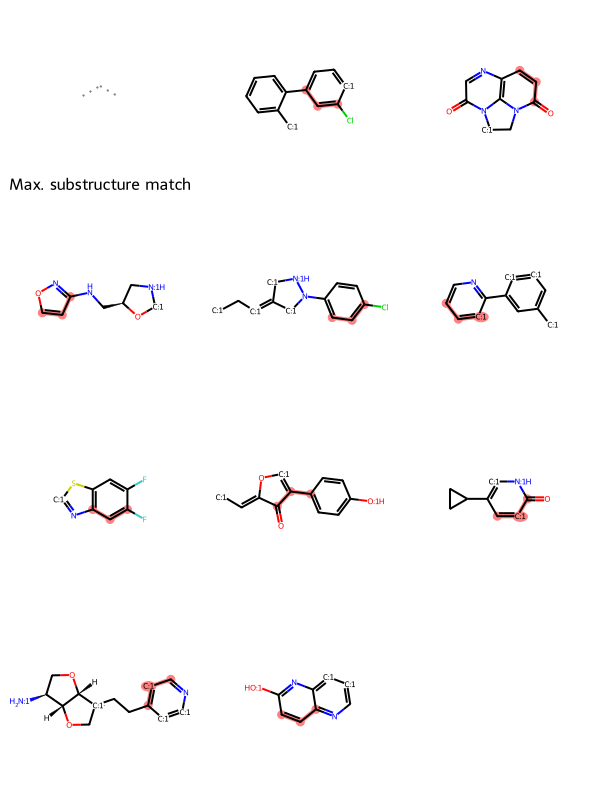

In [284]:
SmilesMCStoGridImage(tmp['rationale_0_MF'].values, align_substructure=False)

CC(=O)NC[C@@H]1OC(=O)N2c3ccc(-c4ccc(C5(C#N)CC5)nc4)cc3SC[C@@H]12
c1cc2c(cc1[CH3:1])SC[C@H]1[C@H]([CH3:1])O[CH2:1]N21
1
[ 4.492096 -9.507462]


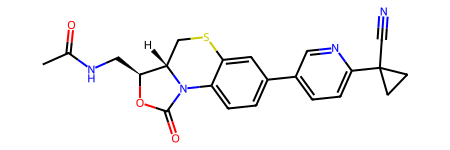

In [175]:
idx = 4
print(tmp.iloc[idx]['Smiles'])
print(tmp.iloc[idx]['rationale_0_MF'])    
print(tmp.iloc[idx]['final_activity_label'])
print(morgan_fps_umap2[tmp.index[idx]])
Chem.MolFromSmiles(tmp.iloc[idx]['Smiles'])

In [177]:
df[df.rationale_0_MF=='c1cc2c(cc1[CH3:1])SC[C@H]1[C@H]([CH3:1])O[CH2:1]N21'].cluster_id.value_counts()

cluster_id
6    11
Name: count, dtype: int64

In [174]:
tmp.iloc[idx]

Smiles                   CC(=O)NC[C@@H]1OC(=O)N2c3ccc(-c4ccc(C5(C#N)CC5...
cluster_id                                                               6
final_activity_label                                                     1
antibiotic_MF                                                     0.670266
rationale_0_MF           c1cc2c(cc1[CH3:1])SC[C@H]1[C@H]([CH3:1])O[CH2:...
rationale_0_score_MF                                              0.330949
antibiotic_RFC                                                     0.94745
rationale_0_RFC              O=C1O[C@@H]([CH3:1])[C@@H]2CS[CH:1]=[CH:1]N12
rationale_0_score_RFC                                             0.207127
is_test                                                               True
rationale_cluster_id                                                     3
Name: 223, dtype: object

## RFC train vs test

In [66]:
df['has_RFC_rationale'] = (~df.rationale_0_RFC.isna())
df[(~df.antibiotic_RFC.isna()) & (df.cluster_id==-1)].groupby(['final_activity_label','has_RFC_rationale'])['Smiles'].count()

final_activity_label  has_RFC_rationale
0                     True                  2
1                     False                 2
                      True                 14
Name: Smiles, dtype: int64

In [69]:
df[(~df.antibiotic_RFC.isna()) & (~df.has_RFC_rationale)& (df.cluster_id==-1)]['Smiles'].tolist()

['CCc1cc(Nc2cc(=O)n(CCCCN3CCN(c4c(F)cc5c(=O)c(C(=O)O)cn(C6CC6)c5c4F)CC3C)c(=O)[nH]2)ccc1C',
 'C[C@@H](O)[C@H]1C(=O)N2C(C(=O)[O-])=C(COc3ccc4cc(Cn5cc[n+](C)c5)ccc4c3)[C@H](C)[C@H]12']

In [89]:
rfc_rationale = df[~df.rationale_0_RFC.isna()].reset_index(drop=True)
rfc_rationale['is_test'] = rfc_rationale.cluster_id==-1 

rfc_rationale.is_test.value_counts()
# print(mf_rationale.is_test.value_counts())


is_test
False    1118
True       16
Name: count, dtype: int64

### Tanimoto Similarity

In [92]:
moleculeSim = []
testDF_rfc = rfc_rationale[rfc_rationale['is_test']].reset_index(drop=True)
trainDF_rfc = rfc_rationale[~rfc_rationale['is_test']].reset_index(drop=True)

test_mfps = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smiles), 3, 2048) for smiles in testDF_rfc['rationale_0_RFC'].values]
train_mfps = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smiles), 3, 2048) for smiles in trainDF_rfc['rationale_0_RFC'].values]

for idx, target_fp in enumerate(test_mfps):
    simMatrix = DataStructs.BulkTanimotoSimilarity(target_fp, train_mfps)
    maxSim = np.max(simMatrix)
    moleculeSim.append(simMatrix)

testDF_rfc['trainMaxSim_idx'] = np.argmax(moleculeSim, axis=1)
testDF_rfc['trainMaxSim_val'] = np.max(moleculeSim, axis=1)

In [100]:
testDF_rfc.final_activity_label.value_counts()

final_activity_label
1    14
0     2
Name: count, dtype: int64

Nc1nc(cs1)/C(=C/CC(=O)O)C(=O)N[C@H]1[C@H]2SCC=C(N2C1=O)C(=O)O
O=C1[C@@H]([NH2:1])[C@H]2SCC=[CH:1]N12


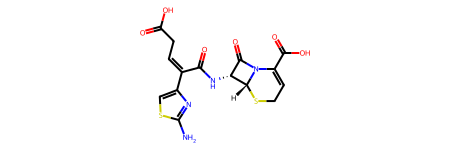

In [45]:
sm = testDF_rfc[testDF_rfc['final_activity_label']==0].iloc[1]
print(sm['Smiles'])
print(sm.rationale_0_RFC)
Chem.MolFromSmiles(sm.Smiles)

In [93]:
cols = ['Smiles','rationale_0_RFC', 'rationale_0_score_RFC','is_test', 'final_activity_label', 'trainMaxSim_idx', 'trainMaxSim_val', 'CID', 'source', 'adjusted_value_uM']
# testDF[testDF.trainMaxSim_val < testDF.trainMaxSim_val.describe()['25%']][cols]
tmpRFC = testDF_rfc[(testDF_rfc.final_activity_label==1) & (testDF_rfc.trainMaxSim_val < 0.3)
       & (~testDF_rfc.is_beta_lactam) & (~testDF_rfc.is_quinolone)][cols]
# tmpRFC = testDF_rfc[(testDF_rfc.final_activity_label==1)
#        & ((testDF_rfc.is_beta_lactam) | (testDF_rfc.is_quinolone))][cols]
tdf = trainDF_rfc.reset_index()[['index', 'Smiles', 'rationale_0_RFC', 'adjusted_value_uM']].rename(columns={
                                   'index':'trainMaxSim_idx',
                                   'Smiles':'closest_match_SMILES',
                                   'rationale_0_RFC':'closest_match_rationale_0_RFC',
                                   'adjusted_value_uM':'closest_match_MIC'})
tmpRFC = tmpRFC.merge(tdf, how='left', on='trainMaxSim_idx')
tmpRFC


Smiles  \
0  Cc1c(N2CC[C@H](N)C2)c(F)cn2c(=O)c(C(=O)O)cc(C3...   

                               rationale_0_RFC  rationale_0_score_RFC  \
0  O=c1n2cc(F)c([NH2:1])[cH:1]c2[cH:1]c[cH:1]1               0.220326   

   is_test  final_activity_label  trainMaxSim_idx  trainMaxSim_val  \
0     True                     1                1         0.238095   

           CID  source  adjusted_value_uM  \
0  CHEMBL16727  ChEMBL           0.086863   

                                closest_match_SMILES  \
0  COc1c(N2C[C@@H]3CCCN[C@@H]3C2)c(F)cc2c(=O)c(C(...   

                     closest_match_rationale_0_RFC  closest_match_MIC  
0  O=c1c2cc(F)c([NH2:1])[cH:1]c2n([CH3:1])c[cH:1]1           4.982065

### Viz

1415 350


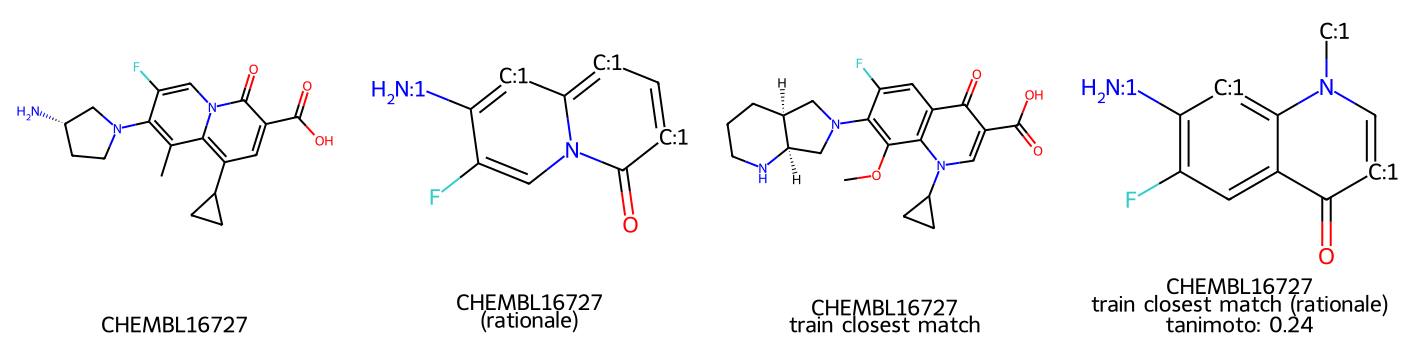

In [97]:
imgs = []
legendFraction = 0.2
legendFontSize = 22
for sm in tmpRFC.itertuples():
    # if sm.cluster_id not in summary[summary['sum']==0].index.values:
    #     continue

    # if sm.cluster_id <13 or sm.cluster_id==-1 or sm.cluster_id>=13:
    #     continue
    # print(sm)
    # break
    uMval = round(sm.adjusted_value_uM, 2)
    d2d = Draw.MolDraw2DCairo(350,350)
    d2d.drawOptions().legendFraction = legendFraction
    d2d.drawOptions().legendFontSize = legendFontSize
    molecule = Chem.MolFromSmiles(sm.Smiles)
    # imgs.append(show_mol(d2d,molecule,legend=f'{sm.CID}\nMIC: {uMval} uM'))
    imgs.append(show_mol(d2d,molecule,legend=f'{sm.CID}'))

for sm in tmpRFC.itertuples():
    d2d = Draw.MolDraw2DCairo(350,350)
    d2d.drawOptions().legendFraction = legendFraction
    d2d.drawOptions().legendFontSize = legendFontSize
    molecule = Chem.MolFromSmiles(sm.rationale_0_RFC)
    imgs.append(show_mol(d2d,molecule,legend=f'{sm.CID}\n(rationale)'))


for sm in tmpRFC.itertuples():
    d2d = Draw.MolDraw2DCairo(350,350)
    d2d.drawOptions().legendFraction = legendFraction
    d2d.drawOptions().legendFontSize = legendFontSize
    molecule = Chem.MolFromSmiles(sm.closest_match_SMILES)
    imgs.append(show_mol(d2d,molecule,legend=f'{sm.CID}\ntrain closest match'))


for sm in tmpRFC.itertuples():
    trainMaxSim_val = round(sm.trainMaxSim_val, 2)
    d2d = Draw.MolDraw2DCairo(350,350)
    d2d.drawOptions().legendFraction = legendFraction
    d2d.drawOptions().legendFontSize = legendFontSize
    molecule = Chem.MolFromSmiles(sm.closest_match_rationale_0_RFC)
    imgs.append(show_mol(d2d,molecule,legend=f'{sm.CID}\ntrain closest match (rationale)\ntanimoto: {trainMaxSim_val}'))

# imgs.append(show_mol(d2d,doravirine,legend='default palette'))
res = show_images(imgs, nrows=tmpRFC.shape[0])
res

In [98]:
res.save(r'imgs\MCTS_rationale_test_train_RFC_low_sim.png', dpi=(1200,1200))

### Random Test

In [62]:
smTest = 'Fc1cc(F)c2n(ccc(=O)c2c1)C1CC1'
rf_scoring_function([smTest])

array([0.36957457])

In [106]:
df[df.CID=='CHEMBL3137691']

Smiles  cluster_id  \
223  CCN(CC)CCS(=O)(=O)[C@@H]1CCN2C(=O)c3coc(n3)CC(...          -1   

     final_activity_label  antibiotic_MF rationale_0_MF  rationale_0_score_MF  \
223                     1       0.797257            NaN                   NaN   

     antibiotic_RFC rationale_0_RFC  rationale_0_score_RFC            CID  \
223             NaN             NaN                    NaN  CHEMBL3137691   

     adjusted_value_uM  source  Molecular_Weight  is_beta_lactam  \
223           0.583737  ChEMBL            1713.1           False   

     is_quinolone  is_common_scaffold  
223         False               False

In [126]:
df[df.CID=='CHEMBL520642']['Smiles'].values[0]

'Nc1nc(/C(=N/O)C(=O)N[C@@H]2C(=O)N3C(C(=O)O)=C(/C=C4\\CCN([C@@H]5CCNC5)C4=O)CS[C@H]23)ns1'

In [118]:
sm1 = df[df.CID=='CHEMBL67247']['Smiles'].values[0]
sm2 = df[df.CID=='CHEMBL520642']['Smiles'].values[0]
fp1 = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(sm1), 3, 2048)
fp2 = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(sm2), 3, 2048)
DataStructs.TanimotoSimilarity(fp1, fp2)

0.38405797101449274

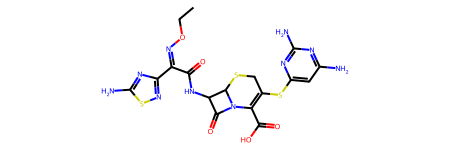

In [119]:
Chem.MolFromSmiles(sm1)

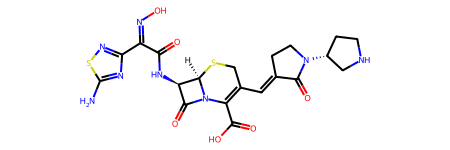

In [120]:
Chem.MolFromSmiles(sm2)